In [2]:
# =============================================================================
# US ACCIDENTS SEVERITY PREDICTION - COMPLETE PIPELINE V2
# =============================================================================
# From data retrieval to trained models (both multi-class and binary)
# Handles imbalanced data with proper sampling
# =============================================================================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("US ACCIDENTS SEVERITY PREDICTION - COMPLETE PIPELINE V2")
print("=" * 80)

# =============================================================================
# PART 1: DATA RETRIEVAL FROM KAGGLE
# =============================================================================
print("\n[PART 1] RETRIEVING DATA FROM KAGGLE")
print("-" * 80)

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Download the dataset
print("Downloading dataset from Kaggle...")
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "sobhanmoosavi/us-accidents",
    "US_Accidents_March23.csv"
)

print(f"✓ Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"✓ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# =============================================================================
# PART 2: INITIAL DATA EXPLORATION
# =============================================================================
print("\n[PART 2] INITIAL DATA EXPLORATION")
print("-" * 80)

print("\nDataset Info:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {df.shape[1]}")
print(f"\nFirst few rows:")
print(df.head(2))

print(f"\nSeverity Distribution (Original):")
severity_dist = df['Severity'].value_counts().sort_index()
for sev, count in severity_dist.items():
    print(f"  Severity {sev}: {count:,} ({count/len(df)*100:.2f}%)")

# =============================================================================
# PART 3: FEATURE ENGINEERING
# =============================================================================
print("\n[PART 3] FEATURE ENGINEERING")
print("-" * 80)

print("\nCreating time-based features...")

# Convert datetime columns
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

# Extract time features
df['year'] = df['Start_Time'].dt.year
df['month'] = df['Start_Time'].dt.month
df['day'] = df['Start_Time'].dt.day
df['hour'] = df['Start_Time'].dt.hour
df['dow'] = df['Start_Time'].dt.dayofweek  # 0=Monday, 6=Sunday

# Create time-based flags
df['is_weekend'] = (df['dow'] >= 5).astype(int)
df['is_morning_peak'] = ((df['hour'] >= 6) & (df['hour'] <= 9)).astype(int)
df['is_evening_peak'] = ((df['hour'] >= 16) & (df['hour'] <= 19)).astype(int)

print("✓ Time features: year, month, day, hour, dow, is_weekend, is_morning_peak, is_evening_peak")

# Create weather condition flags
print("\nCreating weather flags...")

def create_weather_flags(df):
    """Create binary flags for weather conditions"""
    if 'Weather_Condition' not in df.columns:
        return df
    
    weather = df['Weather_Condition'].fillna('').str.lower()
    
    df['is_rain'] = weather.str.contains('rain|drizzle|shower', regex=True).astype(int)
    df['is_snow'] = weather.str.contains('snow|sleet|ice|wintry', regex=True).astype(int)
    df['is_fog'] = weather.str.contains('fog|mist|haze', regex=True).astype(int)
    df['is_thunder'] = weather.str.contains('thunder|t-storm|storm', regex=True).astype(int)
    df['is_wind'] = weather.str.contains('wind', regex=True).astype(int)
    
    return df

df = create_weather_flags(df)

# Check if it's nighttime based on Sunrise_Sunset
if 'Sunrise_Sunset' in df.columns:
    df['is_night'] = (df['Sunrise_Sunset'] == 'Night').astype(int)
else:
    # Estimate based on hour (rough approximation)
    df['is_night'] = ((df['hour'] < 6) | (df['hour'] >= 20)).astype(int)

print("✓ Weather flags: is_rain, is_snow, is_fog, is_thunder, is_wind, is_night")

# =============================================================================
# PART 4: FEATURE SELECTION & DATA CLEANING
# =============================================================================
print("\n[PART 4] FEATURE SELECTION & DATA CLEANING")
print("-" * 80)

# Define feature groups
numeric_features = [
    'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 
    'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 
    'Distance(mi)'
]

boolean_features = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
    'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 
    'Traffic_Calming', 'Traffic_Signal'
]

time_features = [
    'hour', 'dow', 'month', 'year', 'day', 
    'is_weekend', 'is_morning_peak', 'is_evening_peak'
]

weather_flags = [
    'is_rain', 'is_snow', 'is_fog', 'is_thunder', 'is_wind', 'is_night'
]

# Combine all features
all_features = []
for feature in numeric_features + boolean_features + time_features + weather_flags:
    if feature in df.columns:
        all_features.append(feature)
    else:
        print(f"⚠️  Warning: Feature '{feature}' not found in dataset")

print(f"\nTotal features selected: {len(all_features)}")
print(f"  - Numeric: {len([f for f in numeric_features if f in all_features])}")
print(f"  - Boolean: {len([f for f in boolean_features if f in all_features])}")
print(f"  - Time: {len([f for f in time_features if f in all_features])}")
print(f"  - Weather flags: {len([f for f in weather_flags if f in all_features])}")

# Create ML dataframe
print("\nCreating ML dataset...")
ml_df = df[all_features + ['Severity']].copy()

print(f"Before dropping NaN: {len(ml_df):,} rows")
ml_df = ml_df.dropna()
print(f"After dropping NaN: {len(ml_df):,} rows")

# =============================================================================
# PART 5: HANDLE CLASS IMBALANCE
# =============================================================================
print("\n[PART 5] HANDLING CLASS IMBALANCE (CRITICAL)")
print("-" * 80)

print("\n⚠️  ORIGINAL Distribution (IMBALANCED):")
for sev, count in ml_df['Severity'].value_counts().sort_index().items():
    pct = count / len(ml_df) * 100
    bar = '█' * int(pct / 2)
    print(f"  Severity {sev}: {count:,} ({pct:.1f}%) {bar}")

# Determine sampling strategy
min_class_size = ml_df['Severity'].value_counts().min()
print(f"\nSmallest class has: {min_class_size:,} samples")

# Use up to 12,000 samples per class (or all samples if class is smaller)
SAMPLES_PER_CLASS = min(min_class_size, 12000)

print(f"\nBalancing strategy: Sample {SAMPLES_PER_CLASS:,} from each severity level")

# Balanced sampling
ml_df_balanced = ml_df.groupby('Severity', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), SAMPLES_PER_CLASS), random_state=42)
)

print(f"\n✅ BALANCED Distribution:")
for sev, count in ml_df_balanced['Severity'].value_counts().sort_index().items():
    pct = count / len(ml_df_balanced) * 100
    bar = '█' * int(pct / 2)
    print(f"  Severity {sev}: {count:,} ({pct:.1f}%) {bar}")

print(f"\nTotal samples for training: {len(ml_df_balanced):,}")

# =============================================================================
# PART 6: PREPARE DATA FOR MULTI-CLASS CLASSIFICATION
# =============================================================================
print("\n[PART 6] PREPARING MULTI-CLASS CLASSIFICATION (4 Classes: 1,2,3,4)")
print("-" * 80)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Separate features and target
multiclass_X = ml_df_balanced.drop('Severity', axis=1)
multiclass_y = ml_df_balanced['Severity']

# Encode labels (1,2,3,4 → 0,1,2,3)
label_encoder = LabelEncoder()
multiclass_y_encoded = label_encoder.fit_transform(multiclass_y)

print(f"Features: {multiclass_X.shape[1]}")
print(f"Samples: {len(multiclass_y_encoded):,}")
print(f"Classes: {label_encoder.classes_}")

# Train-test split (80/20) with stratification
multiclass_X_train, multiclass_X_test, multiclass_y_train, multiclass_y_test = train_test_split(
    multiclass_X, multiclass_y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=multiclass_y_encoded
)

print(f"\nMulti-class split:")
print(f"  Training: {len(multiclass_X_train):,} samples")
print(f"  Testing: {len(multiclass_X_test):,} samples")

# Scale features
multiclass_scaler = StandardScaler()
multiclass_X_train_scaled = multiclass_scaler.fit_transform(multiclass_X_train)
multiclass_X_test_scaled = multiclass_scaler.transform(multiclass_X_test)

# Store feature names
multiclass_feature_names = multiclass_X.columns.tolist()

print("✓ Data scaled and ready for training")

# =============================================================================
# PART 7: PREPARE DATA FOR BINARY CLASSIFICATION
# =============================================================================
print("\n[PART 7] PREPARING BINARY CLASSIFICATION (2 Classes: LOW/HIGH)")
print("-" * 80)

# Create binary target: Severity 1,2 → LOW (0), Severity 3,4 → HIGH (1)
binary_y = ml_df_balanced['Severity'].map({1: 0, 2: 0, 3: 1, 4: 1})

print("Binary mapping:")
print("  Severity 1,2 → LOW (0)")
print("  Severity 3,4 → HIGH (1)")

print(f"\nBinary distribution:")
for cls, count in binary_y.value_counts().sort_index().items():
    label = "LOW" if cls == 0 else "HIGH"
    print(f"  {label} ({cls}): {count:,} ({count/len(binary_y)*100:.1f}%)")

# Train-test split for binary
binary_X_train, binary_X_test, binary_y_train, binary_y_test = train_test_split(
    multiclass_X, binary_y, 
    test_size=0.2, 
    random_state=42, 
    stratify=binary_y
)

print(f"\nBinary split:")
print(f"  Training: {len(binary_X_train):,} samples")
print(f"  Testing: {len(binary_X_test):,} samples")

# Scale features for binary
binary_scaler = StandardScaler()
binary_X_train_scaled = binary_scaler.fit_transform(binary_X_train)
binary_X_test_scaled = binary_scaler.transform(binary_X_test)

# Store feature names
binary_feature_names = binary_X_train.columns.tolist()

print("✓ Binary data scaled and ready for training")

# =============================================================================
# PART 8: TRAIN MULTI-CLASS MODELS (4 SEVERITY LEVELS)
# =============================================================================
print("\n[PART 8] TRAINING MULTI-CLASS MODELS")
print("=" * 80)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Check for optional libraries
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except (ImportError, Exception) as e:
    XGBOOST_AVAILABLE = False
    if 'OpenMP' in str(e) or 'libomp' in str(e):
        print("⚠️  XGBoost not available (OpenMP issue on Mac)")
        print("   → Using Gradient Boosting v2 instead")
    else:
        print("⚠️  XGBoost not available")

try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except (ImportError, Exception) as e:
    LIGHTGBM_AVAILABLE = False
    if 'OpenMP' in str(e) or 'libomp' in str(e):
        print("⚠️  LightGBM not available (OpenMP issue on Mac)")
        print("   → Using Neural Network instead")
    else:
        print("⚠️  LightGBM not available")

# Define models
multiclass_models = {
    '1. Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=42, 
        multi_class='multinomial',
        n_jobs=-1
    ),
    '2. Decision Tree': DecisionTreeClassifier(
        max_depth=20,
        min_samples_split=10,
        random_state=42
    ),
    '3. Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),
    '4. Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150,
        max_depth=8,
        learning_rate=0.1,
        random_state=42
    ),
    '5. K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        n_jobs=-1
    )
}

# Add XGBoost if available
if XGBOOST_AVAILABLE:
    multiclass_models['6. XGBoost'] = XGBClassifier(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
else:
    multiclass_models['6. Gradient Boosting v2'] = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.15,
        random_state=42
    )

# Add LightGBM if available
if LIGHTGBM_AVAILABLE:
    multiclass_models['7. LightGBM'] = LGBMClassifier(
        n_estimators=200,
        max_depth=15,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
else:
    from sklearn.neural_network import MLPClassifier
    multiclass_models['7. Neural Network'] = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        max_iter=300,
        random_state=42,
        early_stopping=True
    )

# Train models
multiclass_results = {}
multiclass_predictions = {}
multiclass_probabilities = {}

print(f"\nTraining {len(multiclass_models)} models...")
print("-" * 80)

for name, model in multiclass_models.items():
    print(f"\n{name}")
    print("  " + "-" * 40)
    
    # Determine if scaling is needed
    needs_scaling = any(x in name for x in ['Logistic', 'KNN', 'Neighbors', 'Neural'])
    
    # Train model
    if needs_scaling:
        model.fit(multiclass_X_train_scaled, multiclass_y_train)
        y_pred = model.predict(multiclass_X_test_scaled)
        y_prob = model.predict_proba(multiclass_X_test_scaled)
    else:
        model.fit(multiclass_X_train, multiclass_y_train)
        y_pred = model.predict(multiclass_X_test)
        y_prob = model.predict_proba(multiclass_X_test)
    
    # Store predictions
    multiclass_predictions[name] = y_pred
    multiclass_probabilities[name] = y_prob
    
    # Calculate metrics
    multiclass_results[name] = {
        'Accuracy': accuracy_score(multiclass_y_test, y_pred),
        'Precision': precision_score(multiclass_y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(multiclass_y_test, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(multiclass_y_test, y_pred, average='weighted', zero_division=0)
    }
    
    print(f"  Accuracy:  {multiclass_results[name]['Accuracy']:.4f}")
    print(f"  Precision: {multiclass_results[name]['Precision']:.4f}")
    print(f"  Recall:    {multiclass_results[name]['Recall']:.4f}")
    print(f"  F1-Score:  {multiclass_results[name]['F1-Score']:.4f}")

print("\n" + "=" * 80)
print("✅ MULTI-CLASS TRAINING COMPLETE!")
print("=" * 80)

# =============================================================================
# PART 9: TRAIN BINARY MODELS (LOW vs HIGH SEVERITY)
# =============================================================================
print("\n[PART 9] TRAINING BINARY CLASSIFICATION MODELS")
print("=" * 80)

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

# Define binary models (include additional models suitable for binary)
binary_models = {
    '1. Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    ),
    '2. Decision Tree': DecisionTreeClassifier(
        max_depth=20,
        min_samples_split=10,
        random_state=42
    ),
    '3. Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),
    '4. Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150,
        max_depth=8,
        learning_rate=0.1,
        random_state=42
    ),
    '5. K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        n_jobs=-1
    ),
    '6. Naive Bayes': GaussianNB(),
    '7. AdaBoost': AdaBoostClassifier(
        n_estimators=100,
        learning_rate=1.0,
        random_state=42
    )
}

# Add XGBoost if available
if XGBOOST_AVAILABLE:
    binary_models['8. XGBoost'] = XGBClassifier(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )

# Train binary models
binary_results = {}
binary_predictions = {}
binary_probabilities = {}

print(f"\nTraining {len(binary_models)} models...")
print("-" * 80)

for name, model in binary_models.items():
    print(f"\n{name}")
    print("  " + "-" * 40)
    
    # Determine if scaling is needed
    needs_scaling = any(x in name for x in ['Logistic', 'KNN', 'Neighbors', 'Neural', 'Naive'])
    
    # Train model
    if needs_scaling:
        model.fit(binary_X_train_scaled, binary_y_train)
        y_pred = model.predict(binary_X_test_scaled)
        y_prob = model.predict_proba(binary_X_test_scaled)[:, 1]  # Probability of HIGH class
    else:
        model.fit(binary_X_train, binary_y_train)
        y_pred = model.predict(binary_X_test)
        y_prob = model.predict_proba(binary_X_test)[:, 1]
    
    # Store predictions
    binary_predictions[name] = y_pred
    binary_probabilities[name] = y_prob
    
    # Calculate metrics
    binary_results[name] = {
        'Accuracy': accuracy_score(binary_y_test, y_pred),
        'Precision': precision_score(binary_y_test, y_pred, zero_division=0),
        'Recall': recall_score(binary_y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(binary_y_test, y_pred, zero_division=0),
        'AUC-ROC': roc_auc_score(binary_y_test, y_prob)
    }
    
    print(f"  Accuracy:  {binary_results[name]['Accuracy']:.4f}")
    print(f"  Precision: {binary_results[name]['Precision']:.4f}")
    print(f"  Recall:    {binary_results[name]['Recall']:.4f}")
    print(f"  F1-Score:  {binary_results[name]['F1-Score']:.4f}")
    print(f"  AUC-ROC:   {binary_results[name]['AUC-ROC']:.4f}")

print("\n" + "=" * 80)
print("✅ BINARY CLASSIFICATION TRAINING COMPLETE!")
print("=" * 80)

# =============================================================================
# PART 10: SUMMARY & MODEL RANKINGS
# =============================================================================
print("\n[PART 10] FINAL SUMMARY")
print("=" * 80)

print("\n🏆 MULTI-CLASS MODEL RANKINGS (by Accuracy):")
print("-" * 80)
sorted_multiclass = sorted(multiclass_results.items(), key=lambda x: x[1]['Accuracy'], reverse=True)
for rank, (model, metrics) in enumerate(sorted_multiclass, 1):
    emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print(f"{emoji} {rank}. {model:30} → Acc: {metrics['Accuracy']:.4f} | F1: {metrics['F1-Score']:.4f}")

print("\n🏆 BINARY MODEL RANKINGS (by AUC-ROC):")
print("-" * 80)
sorted_binary = sorted(binary_results.items(), key=lambda x: x[1]['AUC-ROC'], reverse=True)
for rank, (model, metrics) in enumerate(sorted_binary, 1):
    emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print(f"{emoji} {rank}. {model:30} → AUC: {metrics['AUC-ROC']:.4f} | F1: {metrics['F1-Score']:.4f}")

print("\n" + "=" * 80)
print("🎉 TRAINING COMPLETE!")
print("=" * 80)

print("\n📦 Variables created:")
print("  Multi-class:")
print("    - multiclass_models, multiclass_results, multiclass_predictions")
print("    - multiclass_scaler, multiclass_feature_names")
print("    - multiclass_X_train, multiclass_X_test")
print("    - multiclass_y_train, multiclass_y_test")
print("\n  Binary:")
print("    - binary_models, binary_results, binary_predictions")
print("    - binary_scaler, binary_feature_names")
print("    - binary_X_train, binary_X_test")
print("    - binary_y_train, binary_y_test")

print("\n✅ Ready to save models for Streamlit!")
print("   Run the save script to export models to .pkl files")

print("\n" + "=" * 80)

US ACCIDENTS SEVERITY PREDICTION - COMPLETE PIPELINE V2

[PART 1] RETRIEVING DATA FROM KAGGLE
--------------------------------------------------------------------------------
✓ Dataset loaded: 7,728,394 rows × 46 columns
✓ Memory usage: 10870.28 MB

[PART 2] INITIAL DATA EXPLORATION
--------------------------------------------------------------------------------

Dataset Info:
  Shape: (7728394, 46)
  Columns: 46

First few rows:
    ID   Source  Severity           Start_Time             End_Time  \
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  39.865147 -84.058723      NaN      NaN          0.01  ...      False   
1  39.928059 -82.831184      NaN      NaN          0.01  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  \
0   False  False           False          False


[VISUALIZATIONS] Generating Multi-Class Plots...


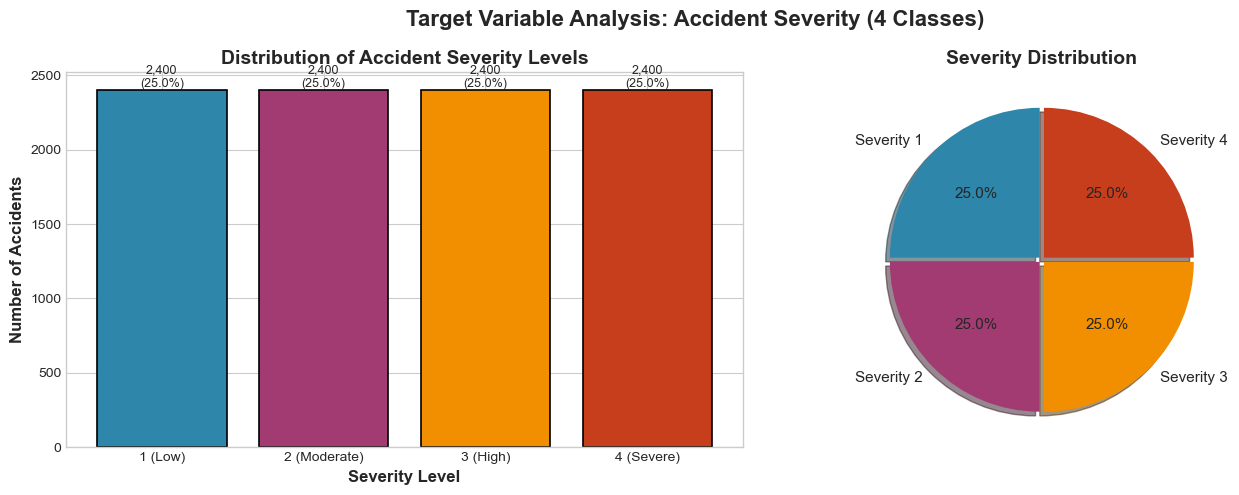

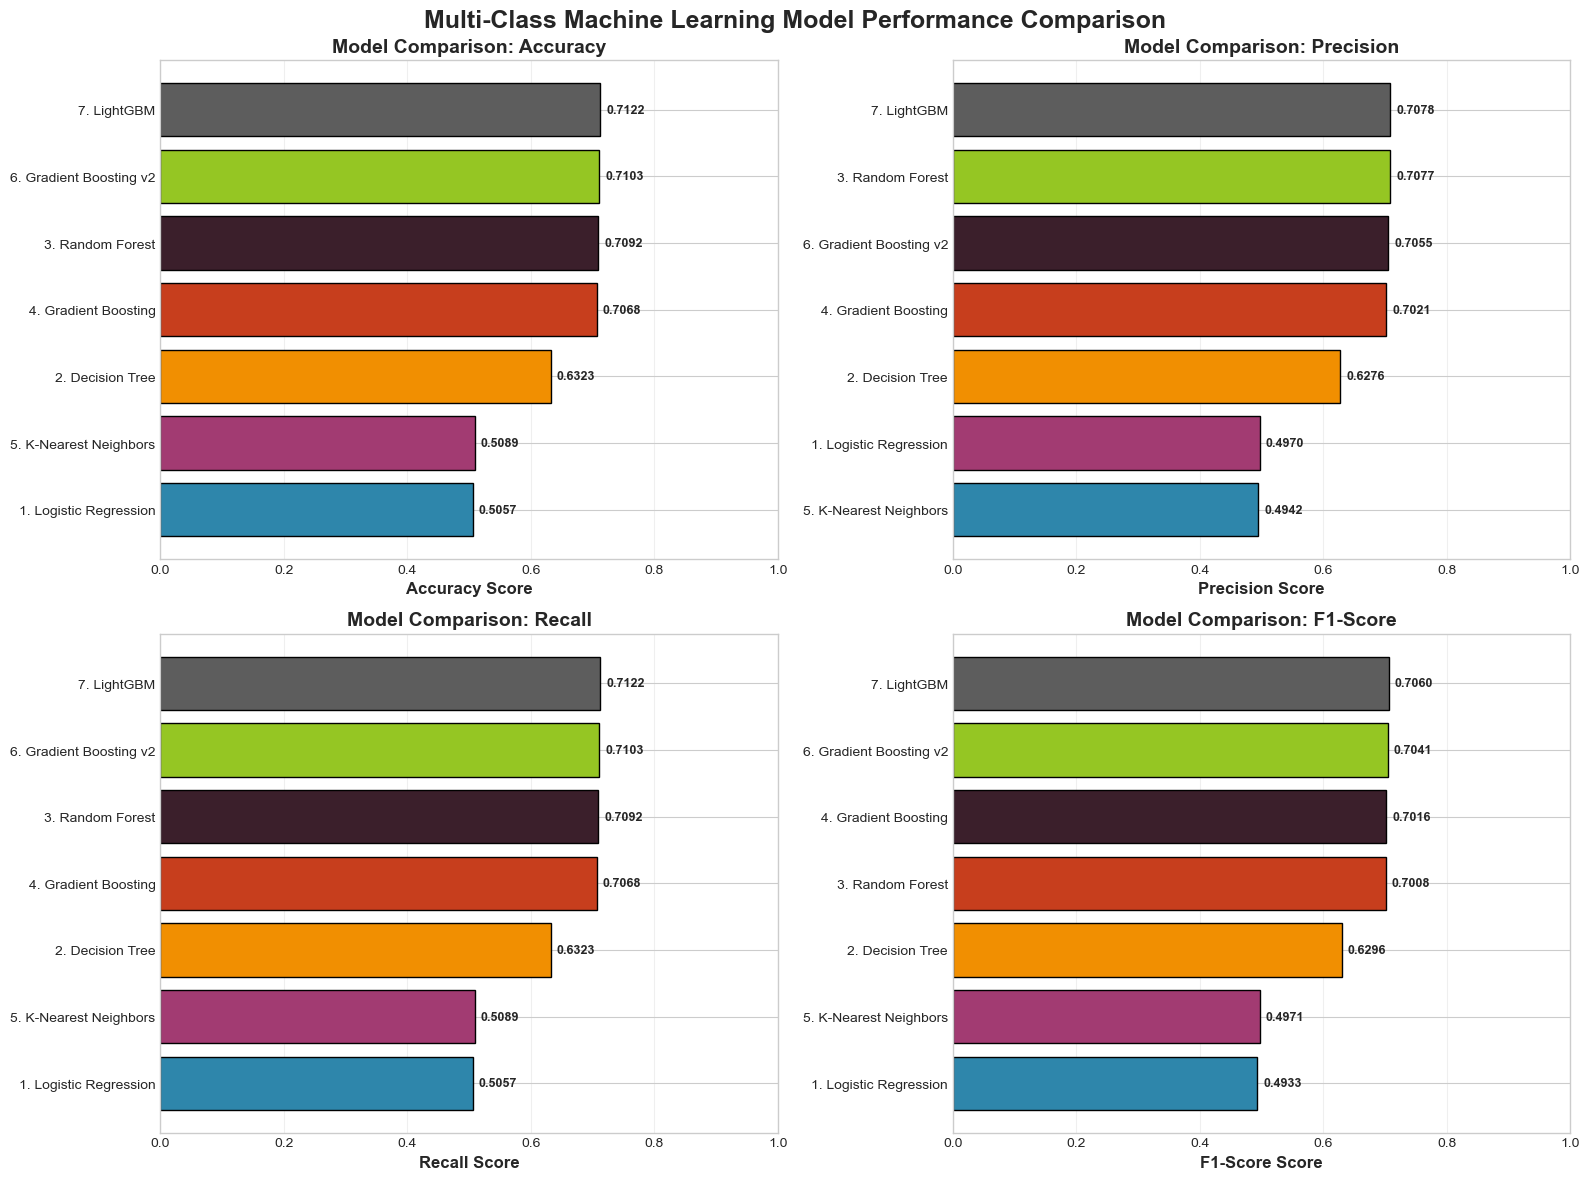

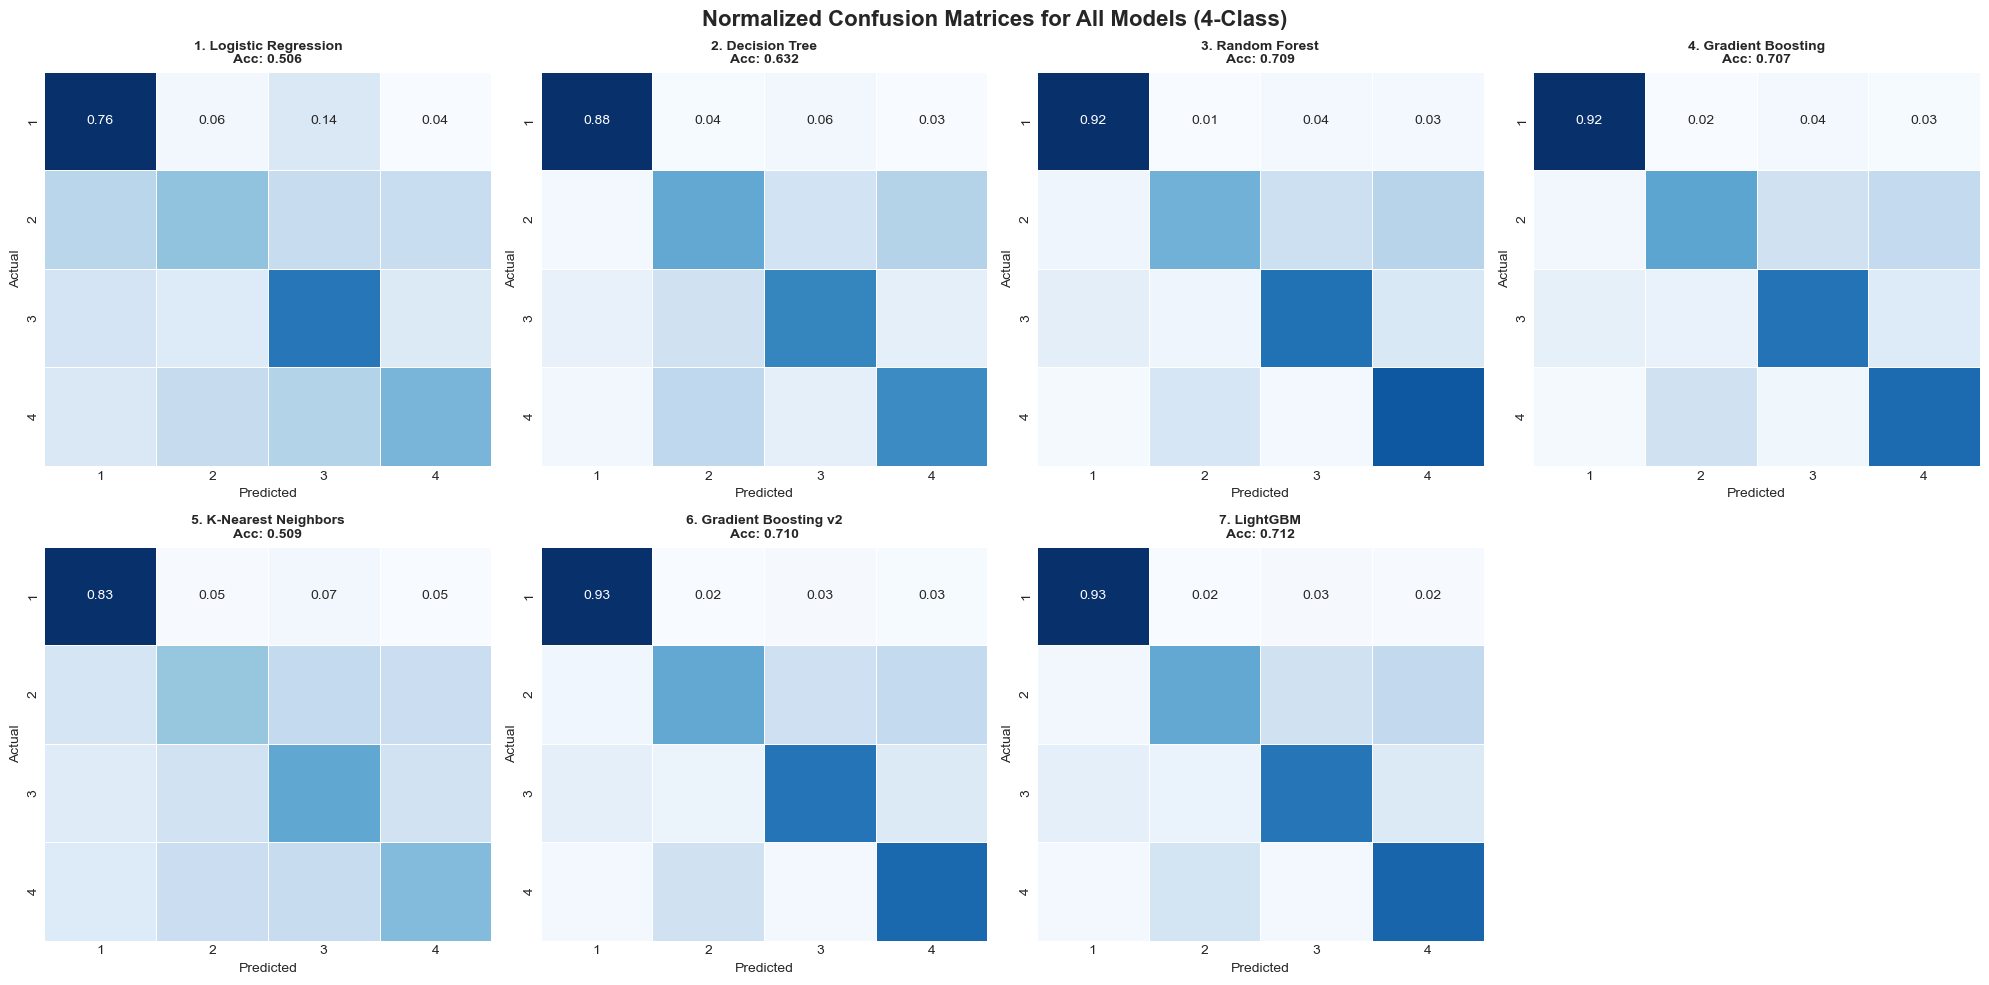

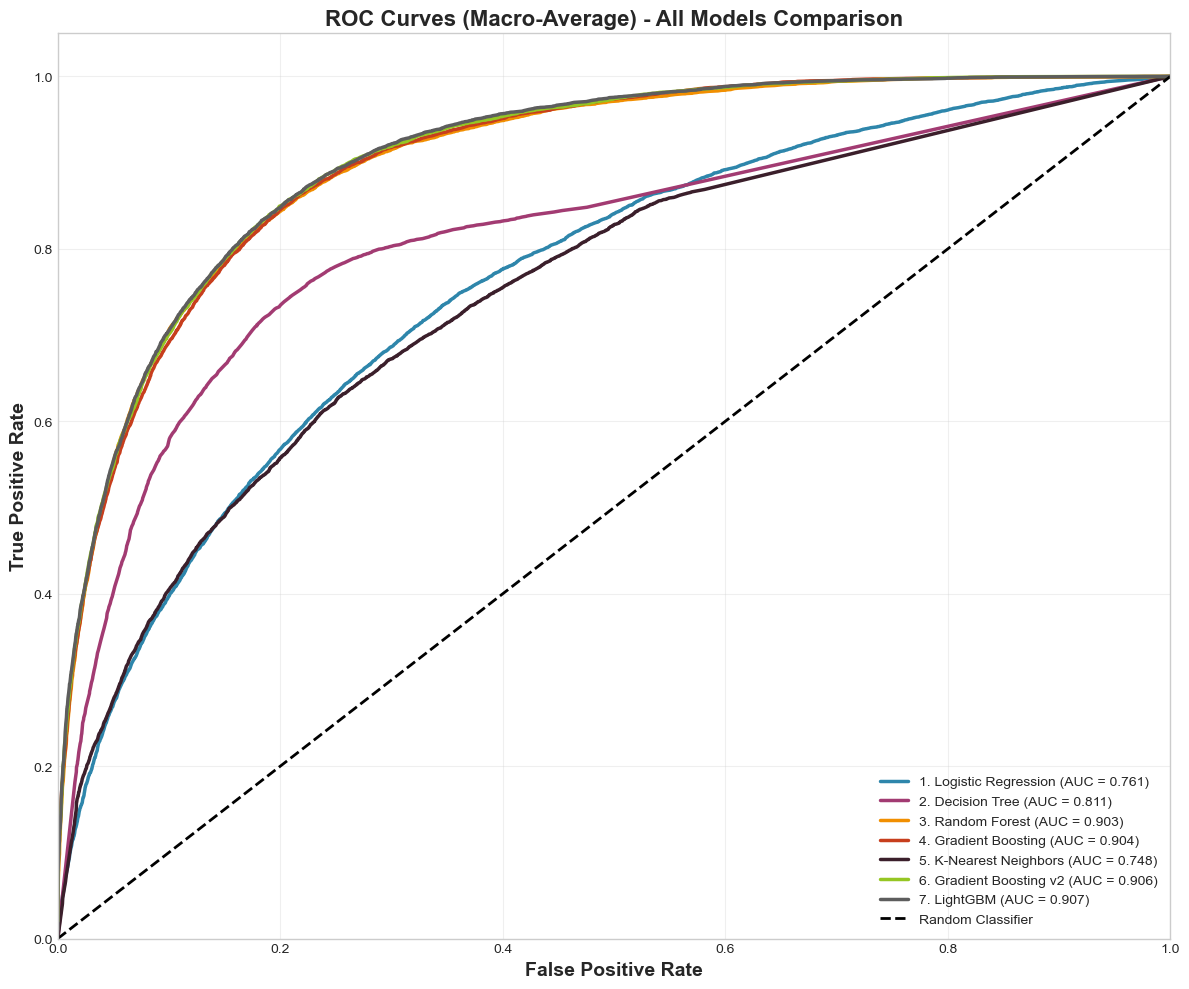

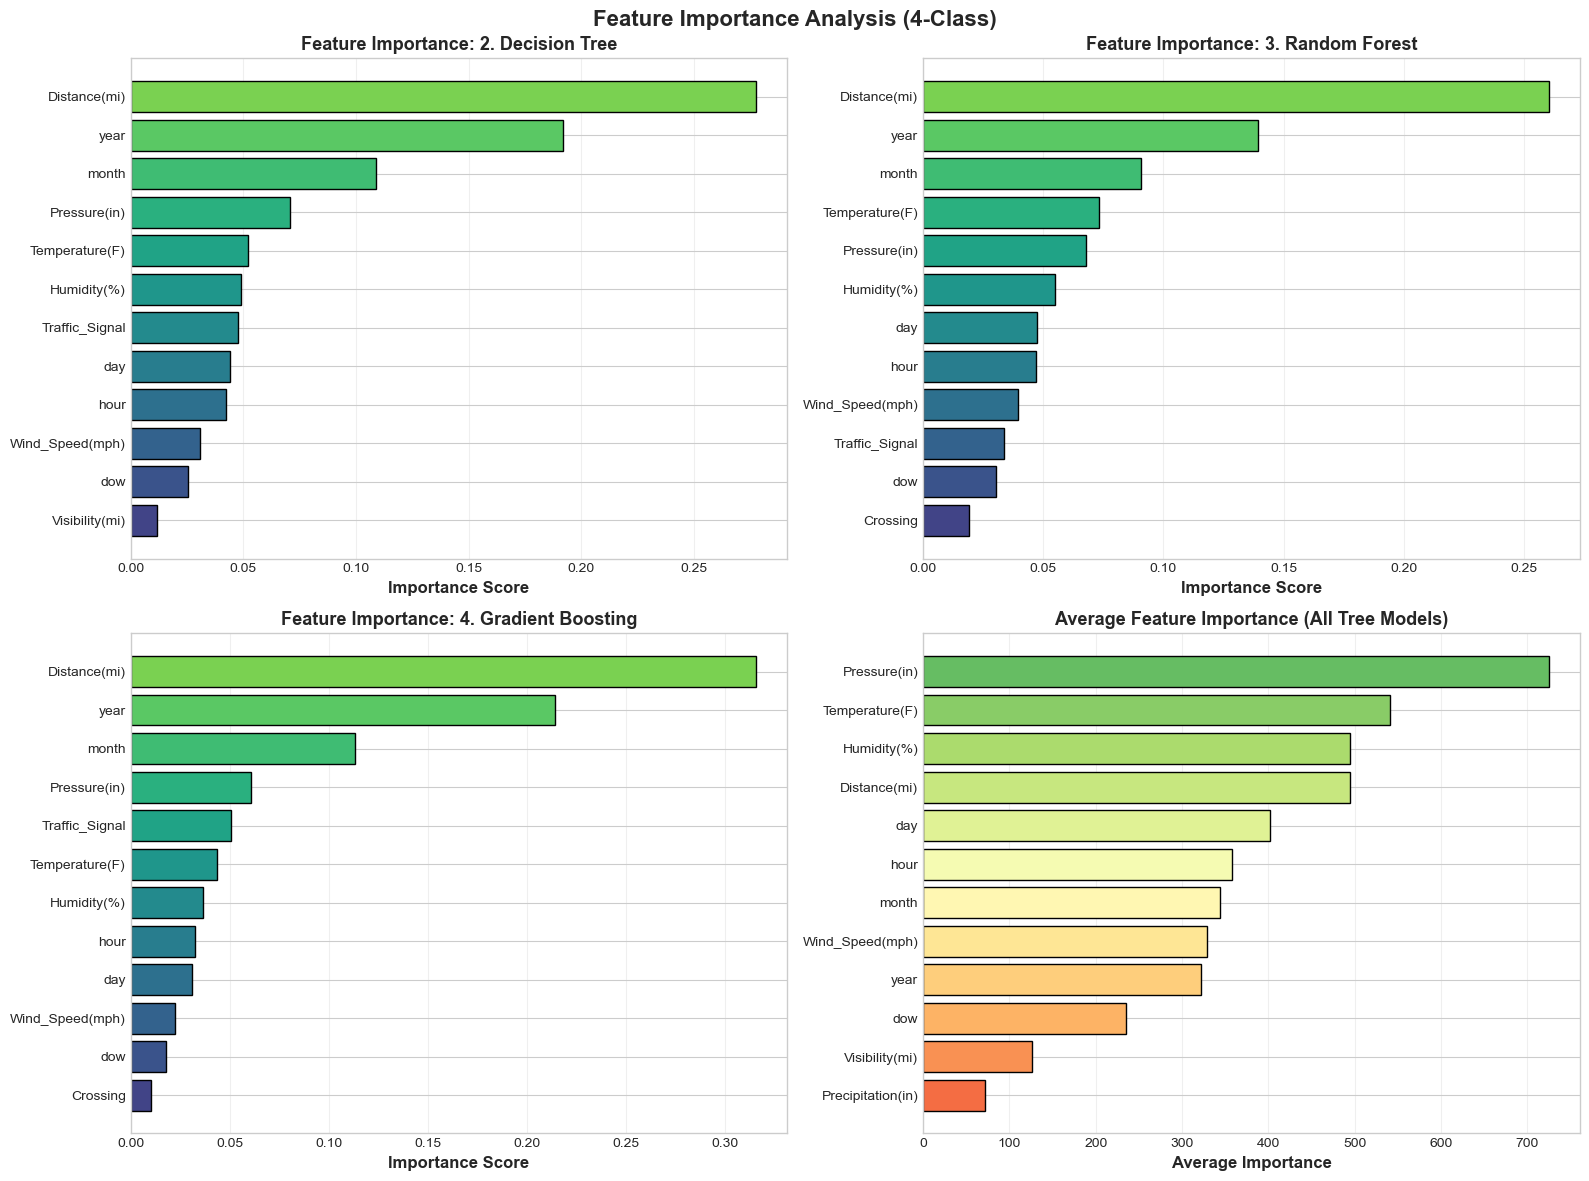

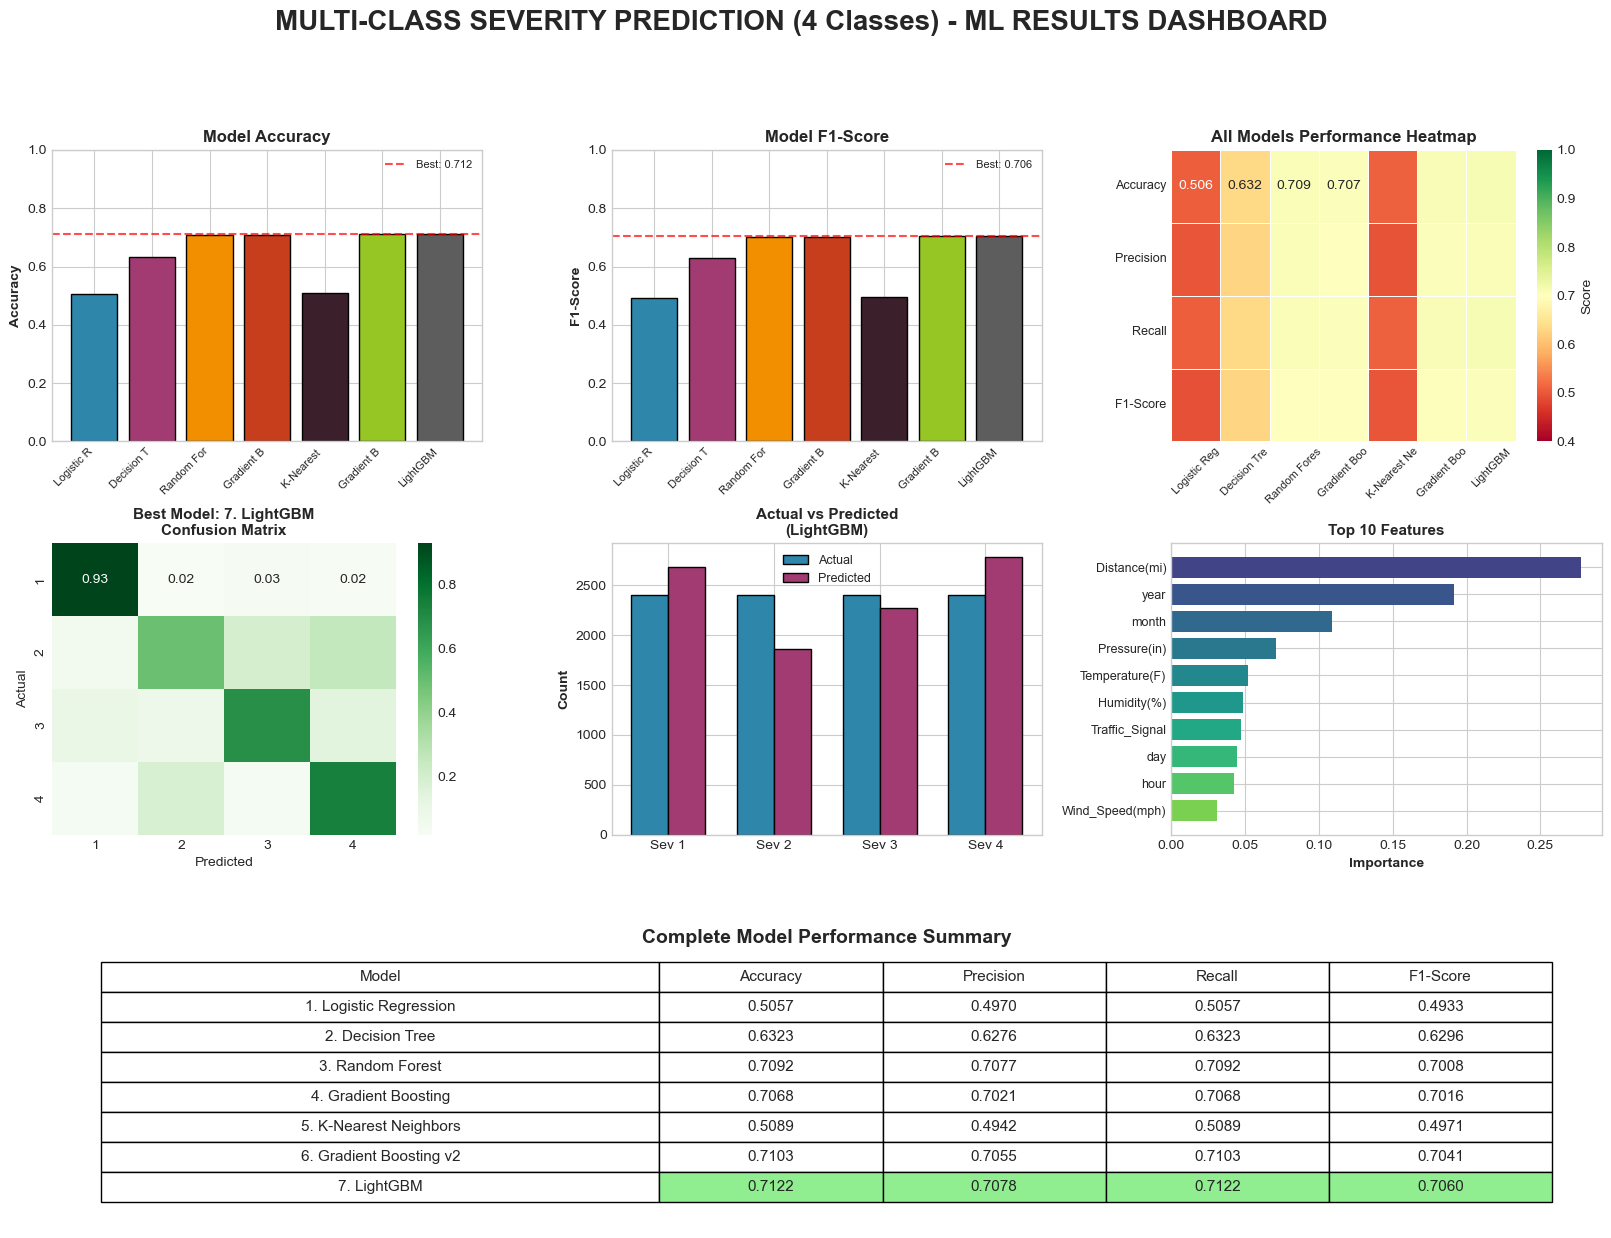


✅ Multi-Class Visualizations Complete!


In [4]:
# =============================================================================
# MULTI-CLASS VISUALIZATIONS (Add after PART 8 training completes)
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#95C623', '#5D5D5D']

# Get class info
multiclass_original_classes = label_encoder.classes_
multiclass_n_classes = len(multiclass_original_classes)

# =============================================================================
# VISUALIZATION 1: CLASS DISTRIBUTION
# =============================================================================
print("\n[VISUALIZATIONS] Generating Multi-Class Plots...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

severity_counts = pd.Series(multiclass_y_test).value_counts().sort_index()
colors_sev = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'][:multiclass_n_classes]

# Bar plot
bars = axes[0].bar(range(len(severity_counts)), severity_counts.values, color=colors_sev, 
                   edgecolor='black', linewidth=1.2)
axes[0].set_xlabel('Severity Level', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Accidents', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Accident Severity Levels', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(multiclass_original_classes)))
severity_names = ['Low', 'Moderate', 'High', 'Severe'][:multiclass_n_classes]
axes[0].set_xticklabels([f'{c} ({severity_names[i]})' for i, c in enumerate(multiclass_original_classes)])

for bar, count in zip(bars, severity_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                f'{count:,}\n({count/len(multiclass_y_test)*100:.1f}%)', ha='center', fontsize=9)

# Pie chart
axes[1].pie(severity_counts.values, 
            labels=[f'Severity {c}' for c in multiclass_original_classes],
            colors=colors_sev, autopct='%1.1f%%', startangle=90, 
            explode=[0.02]*len(severity_counts), shadow=True, textprops={'fontsize': 11})
axes[1].set_title('Severity Distribution', fontsize=14, fontweight='bold')

plt.suptitle('Target Variable Analysis: Accident Severity (4 Classes)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 2: MODEL PERFORMANCE COMPARISON
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

multiclass_results_df = pd.DataFrame(multiclass_results).T
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    sorted_results = multiclass_results_df[metric].sort_values(ascending=True)
    
    bars = ax.barh(range(len(sorted_results)), sorted_results.values, 
                   color=COLORS[:len(sorted_results)], edgecolor='black', linewidth=1)
    
    ax.set_yticks(range(len(sorted_results)))
    ax.set_yticklabels(sorted_results.index, fontsize=10)
    ax.set_xlabel(f'{metric} Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Model Comparison: {metric}', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(True, axis='x', alpha=0.3)
    
    for bar, val in zip(bars, sorted_results.values):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
               f'{val:.4f}', va='center', fontsize=9, fontweight='bold')

plt.suptitle('Multi-Class Machine Learning Model Performance Comparison', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 3: CONFUSION MATRICES
# =============================================================================
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

class_labels = [str(c) for c in multiclass_original_classes]

for idx, (name, y_pred) in enumerate(multiclass_predictions.items()):
    if idx >= 7:
        break
    ax = axes[idx]
    
    cm = confusion_matrix(multiclass_y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                xticklabels=class_labels, yticklabels=class_labels,
                cbar=False, linewidths=0.5, linecolor='white')
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('Actual', fontsize=10)
    ax.set_title(f'{name}\nAcc: {multiclass_results[name]["Accuracy"]:.3f}', fontsize=10, fontweight='bold')

axes[7].axis('off')
plt.suptitle('Normalized Confusion Matrices for All Models (4-Class)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 4: ROC CURVES
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 10))

classes = list(range(multiclass_n_classes))
multiclass_y_test_bin = label_binarize(multiclass_y_test, classes=classes)

for idx, (name, y_prob) in enumerate(multiclass_probabilities.items()):
    fpr = dict()
    tpr = dict()
    
    for i in range(multiclass_n_classes):
        fpr[i], tpr[i], _ = roc_curve(multiclass_y_test_bin[:, i], y_prob[:, i])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(multiclass_n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(multiclass_n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= multiclass_n_classes
    
    macro_auc = auc(all_fpr, mean_tpr)
    ax.plot(all_fpr, mean_tpr, color=COLORS[idx], lw=2.5, 
           label=f'{name} (AUC = {macro_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('ROC Curves (Macro-Average) - All Models Comparison', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 5: FEATURE IMPORTANCE
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Get tree-based models for feature importance
multiclass_importance_models = {}
for name, model in multiclass_models.items():
    if hasattr(model, 'feature_importances_'):
        multiclass_importance_models[name] = model

plot_models = list(multiclass_importance_models.items())[:3]

for idx, (name, model) in enumerate(plot_models):
    ax = axes[idx // 2, idx % 2]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:12]
    
    colors_imp = plt.cm.viridis(np.linspace(0.2, 0.8, len(indices)))[::-1]
    
    ax.barh(range(len(indices)), importances[indices], color=colors_imp, edgecolor='black')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([multiclass_feature_names[i] for i in indices], fontsize=10)
    ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Feature Importance: {name}', fontsize=13, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, axis='x', alpha=0.3)

# Average importance
ax = axes[1, 1]
avg_importance = np.zeros(len(multiclass_feature_names))
for name, model in multiclass_importance_models.items():
    avg_importance += model.feature_importances_
avg_importance /= len(multiclass_importance_models)

indices = np.argsort(avg_importance)[::-1][:12]
colors_imp = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(indices)))[::-1]

ax.barh(range(len(indices)), avg_importance[indices], color=colors_imp, edgecolor='black')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([multiclass_feature_names[i] for i in indices], fontsize=10)
ax.set_xlabel('Average Importance', fontsize=12, fontweight='bold')
ax.set_title('Average Feature Importance (All Tree Models)', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, axis='x', alpha=0.3)

plt.suptitle('Feature Importance Analysis (4-Class)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 6: COMPREHENSIVE SUMMARY DASHBOARD
# =============================================================================
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Accuracy Comparison
ax1 = fig.add_subplot(gs[0, 0])
accuracies = [multiclass_results[m]['Accuracy'] for m in multiclass_models.keys()]
model_short = [m.split('. ')[1][:10] for m in multiclass_models.keys()]
bars = ax1.bar(range(len(multiclass_models)), accuracies, color=COLORS, edgecolor='black')
ax1.set_xticks(range(len(multiclass_models)))
ax1.set_xticklabels(model_short, rotation=45, ha='right', fontsize=8)
ax1.set_ylabel('Accuracy', fontsize=10, fontweight='bold')
ax1.set_title('Model Accuracy', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.axhline(y=max(accuracies), color='red', linestyle='--', alpha=0.7, label=f'Best: {max(accuracies):.3f}')
ax1.legend(fontsize=8)

# 2. F1-Score Comparison
ax2 = fig.add_subplot(gs[0, 1])
f1_scores = [multiclass_results[m]['F1-Score'] for m in multiclass_models.keys()]
bars = ax2.bar(range(len(multiclass_models)), f1_scores, color=COLORS, edgecolor='black')
ax2.set_xticks(range(len(multiclass_models)))
ax2.set_xticklabels(model_short, rotation=45, ha='right', fontsize=8)
ax2.set_ylabel('F1-Score', fontsize=10, fontweight='bold')
ax2.set_title('Model F1-Score', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.axhline(y=max(f1_scores), color='red', linestyle='--', alpha=0.7, label=f'Best: {max(f1_scores):.3f}')
ax2.legend(fontsize=8)

# 3. All Models Heatmap
ax3 = fig.add_subplot(gs[0, 2])
heatmap_data = multiclass_results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
model_labels = [m.split('. ')[1][:12] for m in heatmap_data.index]
sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax3,
            xticklabels=model_labels, yticklabels=heatmap_data.columns,
            cbar_kws={'label': 'Score'}, vmin=0.4, vmax=1.0, linewidths=0.5)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('All Models Performance Heatmap', fontsize=12, fontweight='bold')
ax3.tick_params(axis='x', rotation=45, labelsize=8)
ax3.tick_params(axis='y', rotation=0, labelsize=9)

# 4. Best Model Confusion Matrix
ax4 = fig.add_subplot(gs[1, 0])
best_model = max(multiclass_results.keys(), key=lambda x: multiclass_results[x]['Accuracy'])
cm = confusion_matrix(multiclass_y_test, multiclass_predictions[best_model])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=ax4,
            xticklabels=class_labels, yticklabels=class_labels)
ax4.set_xlabel('Predicted', fontsize=10)
ax4.set_ylabel('Actual', fontsize=10)
ax4.set_title(f'Best Model: {best_model}\nConfusion Matrix', fontsize=11, fontweight='bold')

# 5. Actual vs Predicted Distribution
ax5 = fig.add_subplot(gs[1, 1])
x_pos = np.arange(multiclass_n_classes)
width = 0.35
actual_counts = np.bincount(multiclass_y_test, minlength=multiclass_n_classes)
pred_counts = np.bincount(multiclass_predictions[best_model], minlength=multiclass_n_classes)
ax5.bar(x_pos - width/2, actual_counts, width, label='Actual', color=COLORS[0], edgecolor='black')
ax5.bar(x_pos + width/2, pred_counts, width, label='Predicted', color=COLORS[1], edgecolor='black')
ax5.set_xticks(x_pos)
ax5.set_xticklabels([f'Sev {c}' for c in multiclass_original_classes])
ax5.set_ylabel('Count', fontsize=10, fontweight='bold')
ax5.set_title(f'Actual vs Predicted\n({best_model.split(". ")[1]})', fontsize=11, fontweight='bold')
ax5.legend(fontsize=9)

# 6. Top Features
ax6 = fig.add_subplot(gs[1, 2])
if multiclass_importance_models:
    best_tree_model = list(multiclass_importance_models.values())[0]
    importances = best_tree_model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    ax6.barh(range(10), importances[indices], color=plt.cm.viridis(np.linspace(0.2, 0.8, 10)))
    ax6.set_yticks(range(10))
    ax6.set_yticklabels([multiclass_feature_names[i] for i in indices], fontsize=9)
    ax6.invert_yaxis()
    ax6.set_xlabel('Importance', fontsize=10, fontweight='bold')
    ax6.set_title('Top 10 Features', fontsize=11, fontweight='bold')

# 7. Results Table
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')

table_data = []
for model in multiclass_models.keys():
    row = [model, 
           f"{multiclass_results[model]['Accuracy']:.4f}",
           f"{multiclass_results[model]['Precision']:.4f}",
           f"{multiclass_results[model]['Recall']:.4f}",
           f"{multiclass_results[model]['F1-Score']:.4f}"]
    table_data.append(row)

table = ax7.table(cellText=table_data,
                  colLabels=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                  cellLoc='center', loc='center',
                  colWidths=[0.3, 0.12, 0.12, 0.12, 0.12])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Highlight best values in green
for i, model in enumerate(multiclass_models.keys()):
    for j, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score']):
        max_val = max([multiclass_results[m][metric] for m in multiclass_models.keys()])
        if multiclass_results[model][metric] == max_val:
            table[(i+1, j+1)].set_facecolor('#90EE90')

ax7.set_title('Complete Model Performance Summary', fontsize=14, fontweight='bold', y=0.95)

plt.suptitle('MULTI-CLASS SEVERITY PREDICTION (4 Classes) - ML RESULTS DASHBOARD', 
             fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n✅ Multi-Class Visualizations Complete!")



[VISUALIZATIONS] Generating Binary Classification Plots...


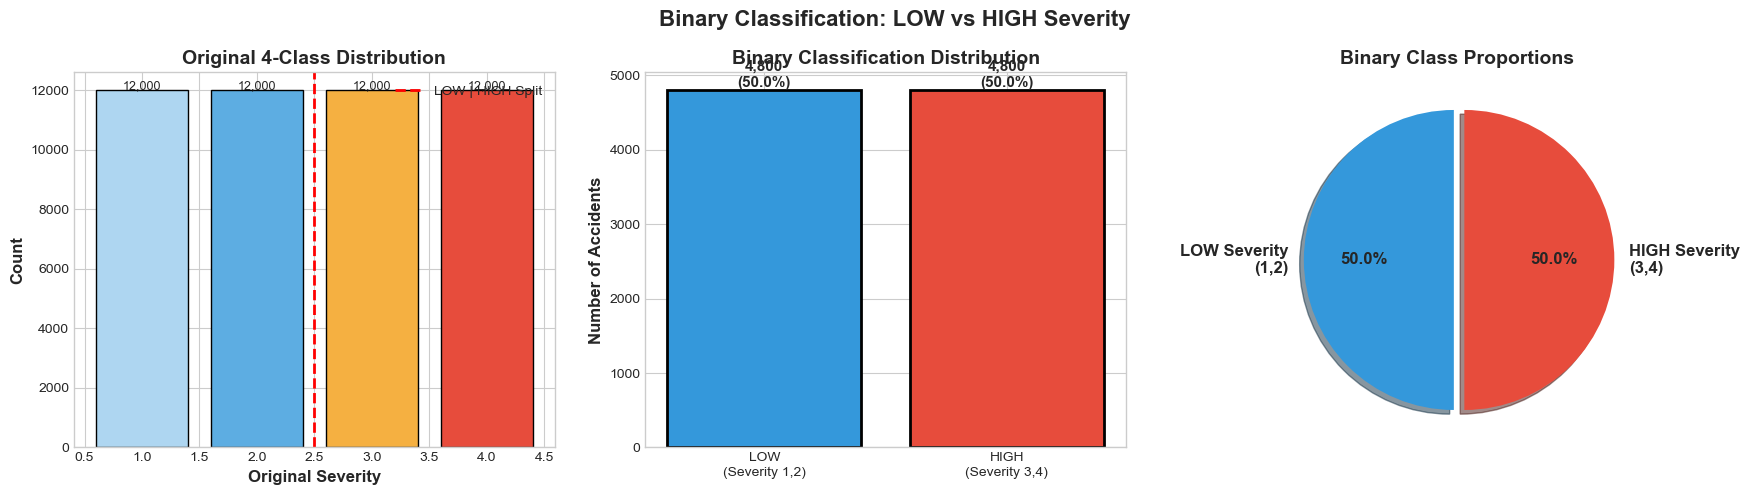

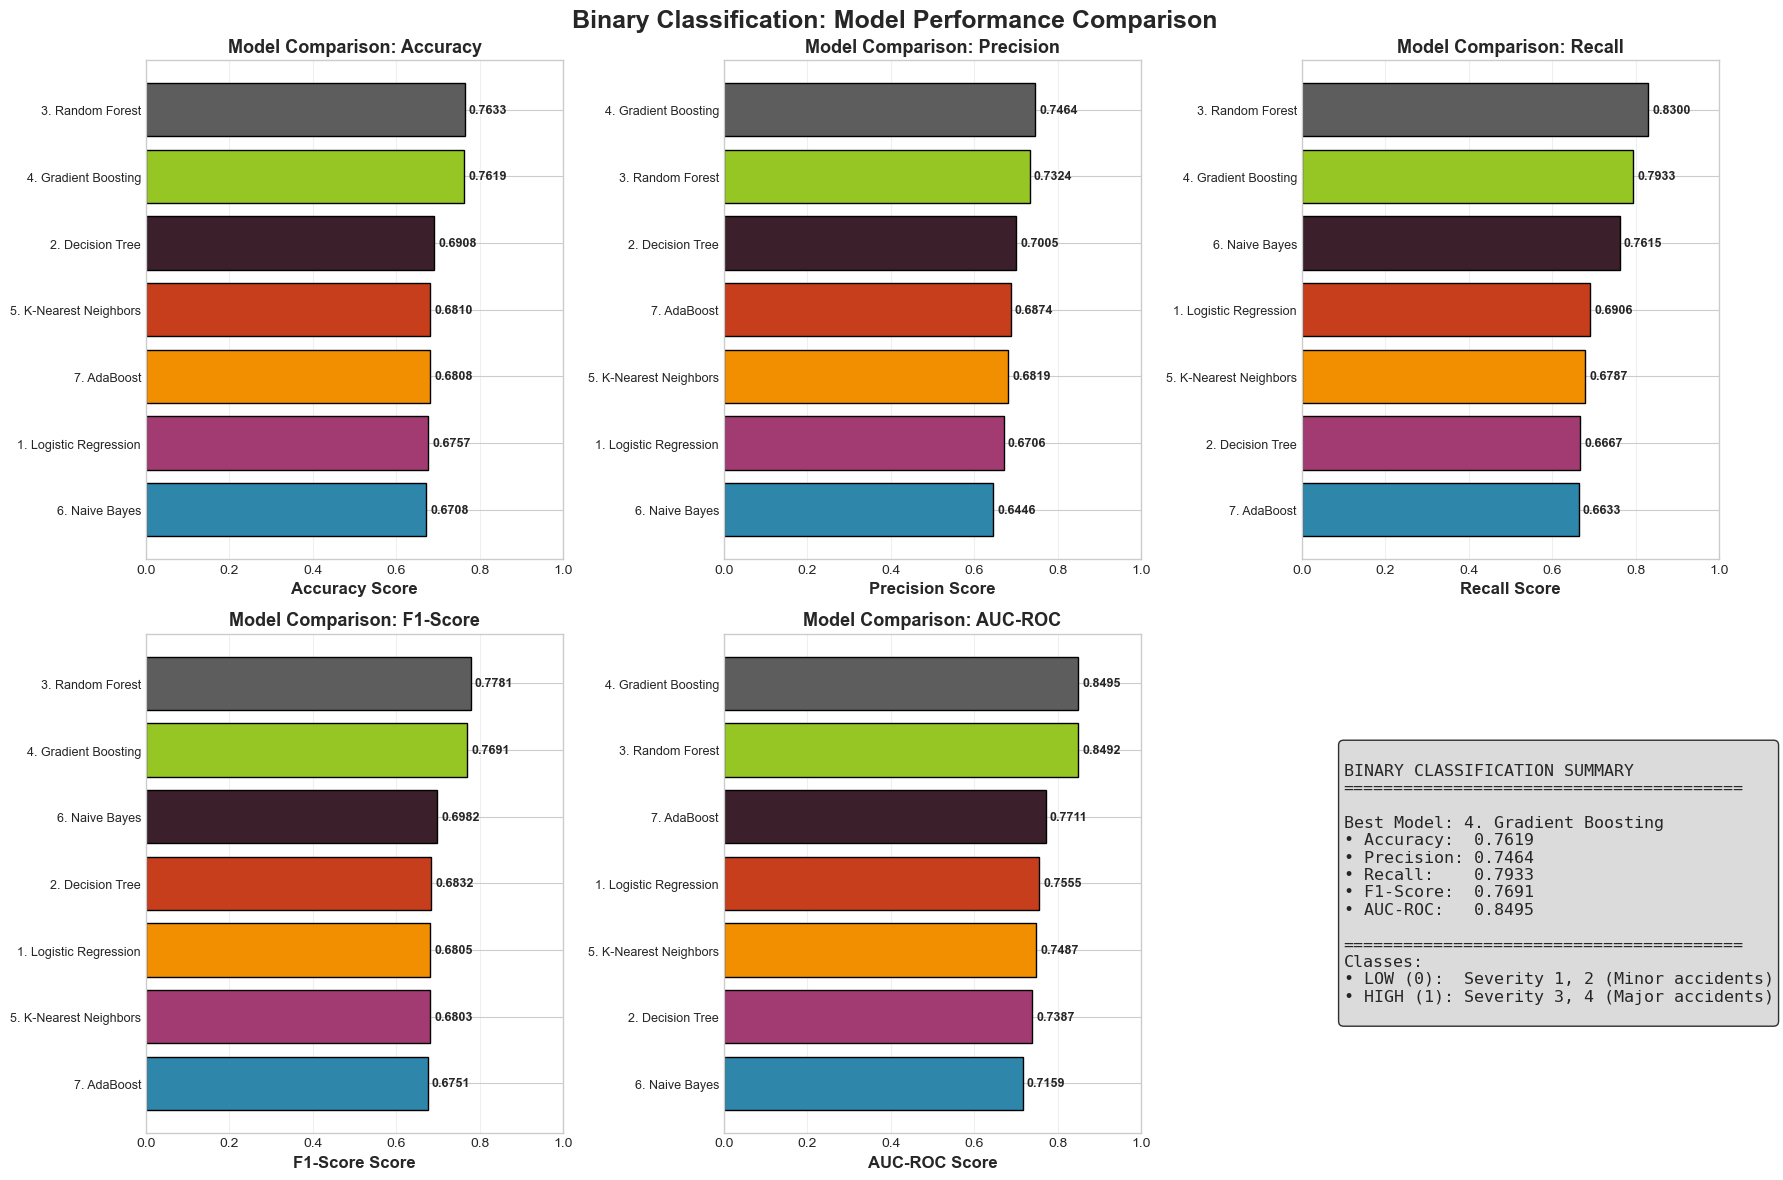

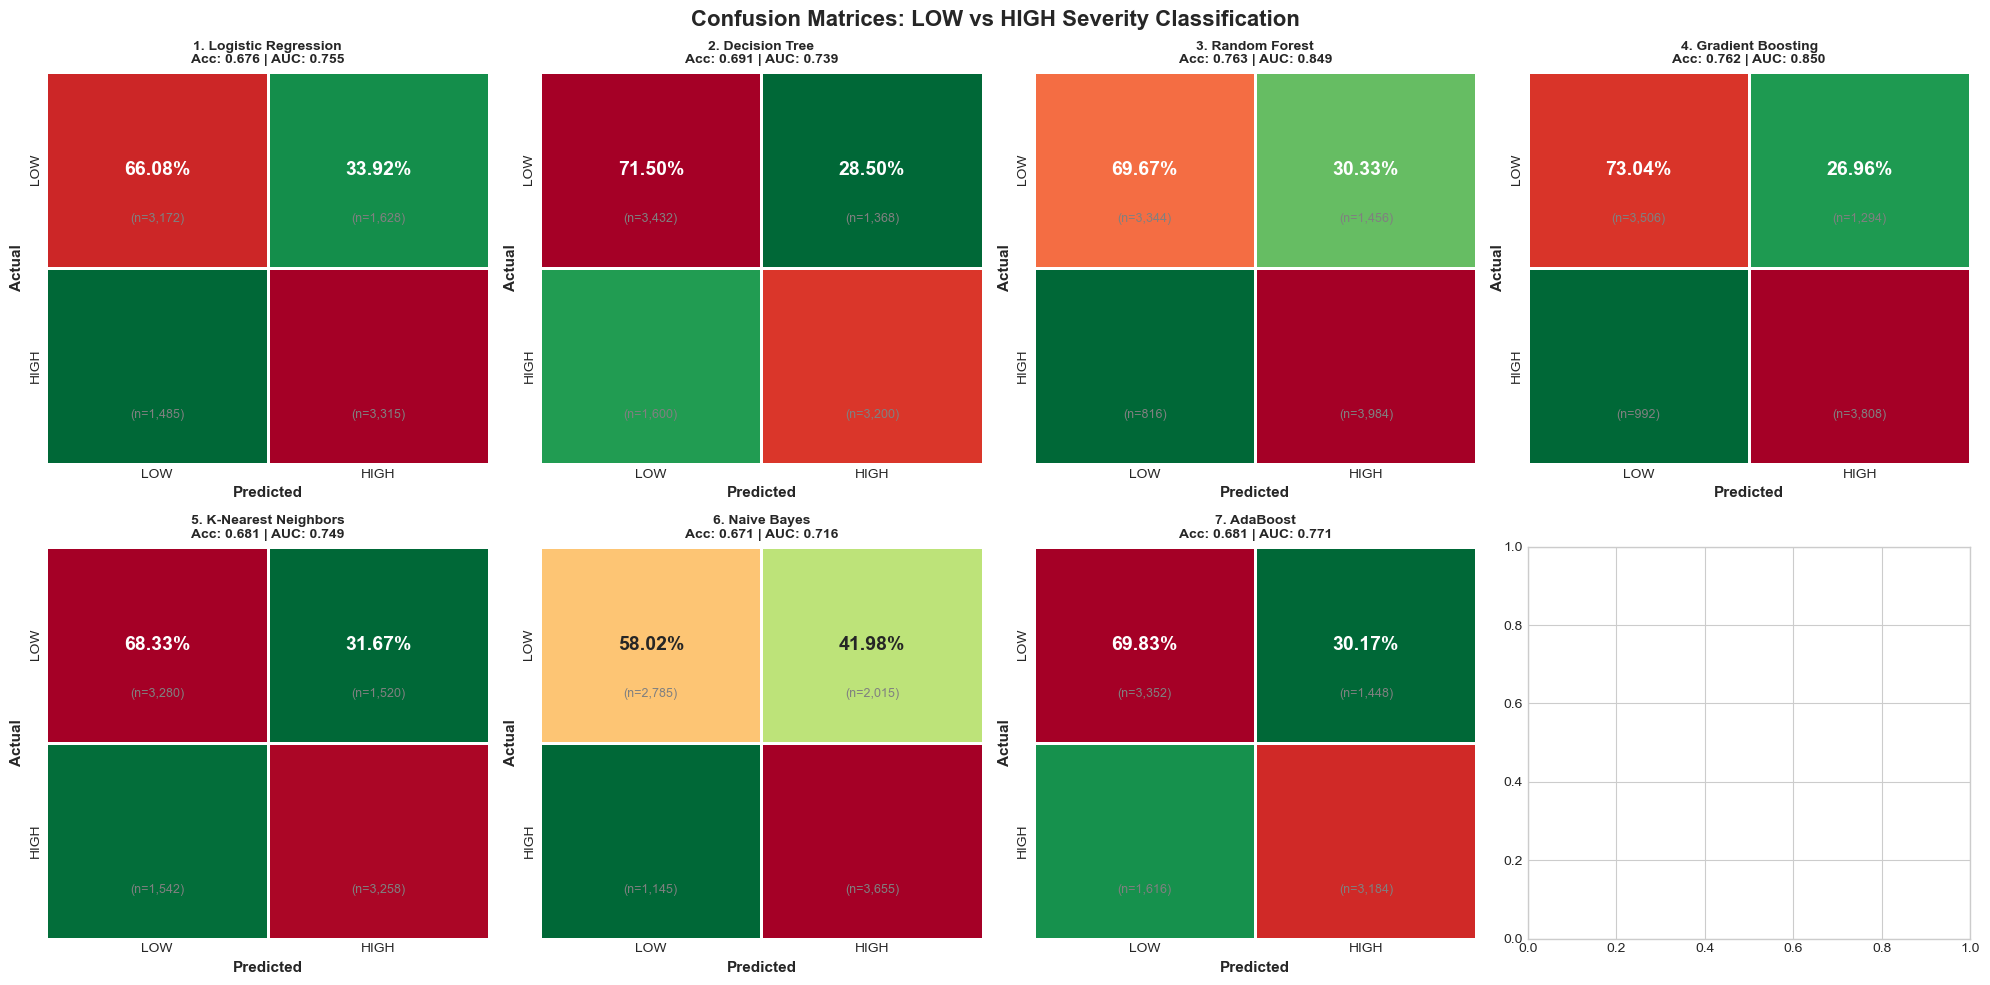

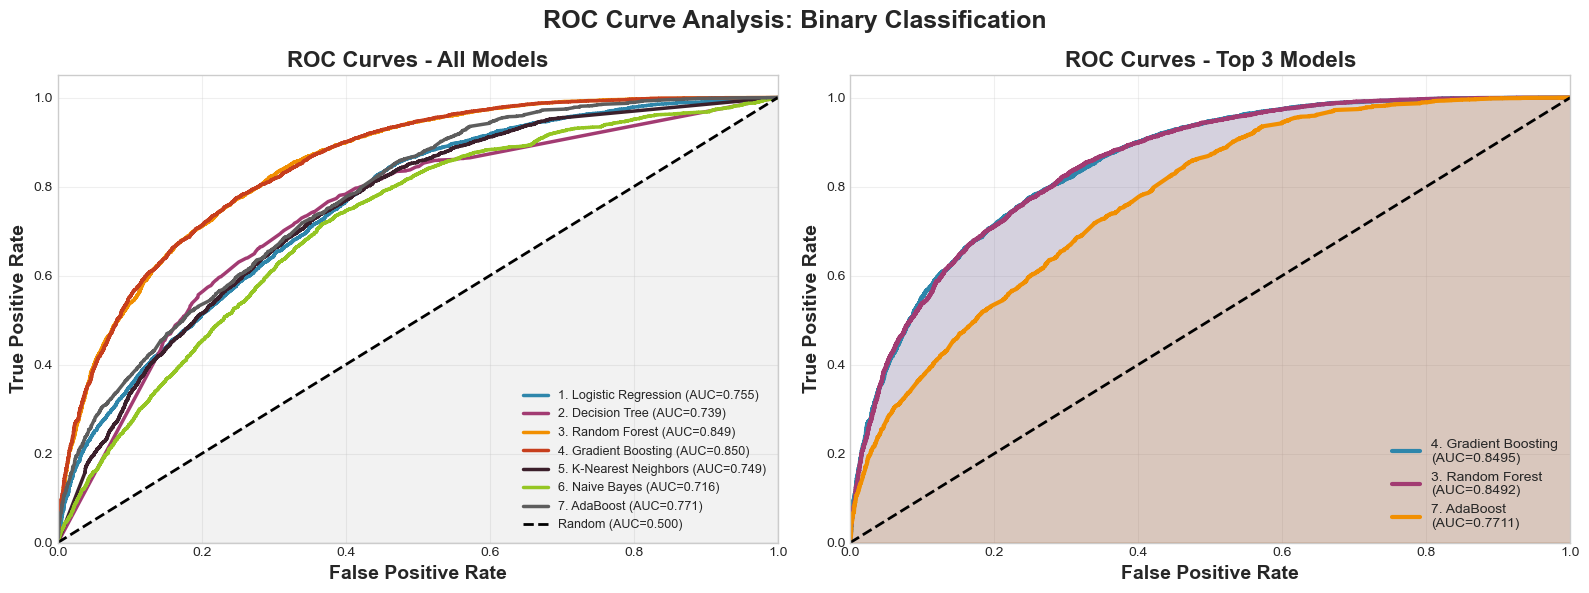

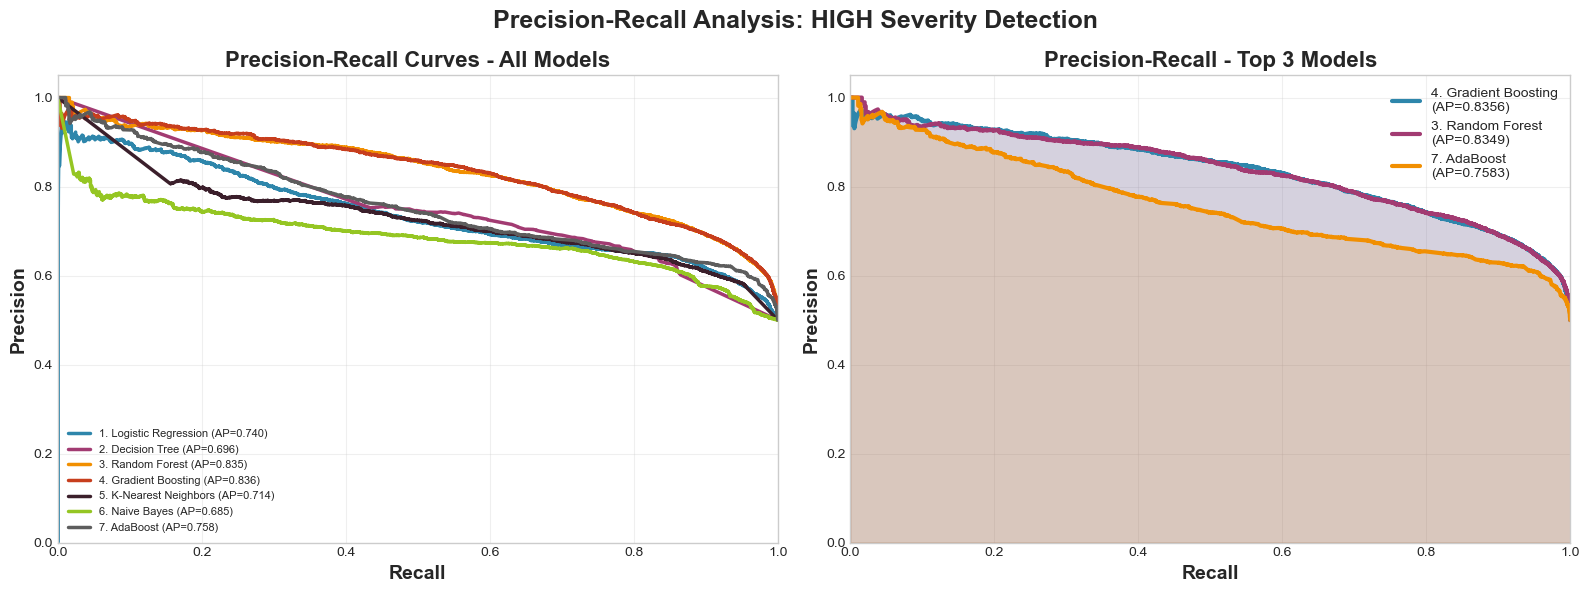

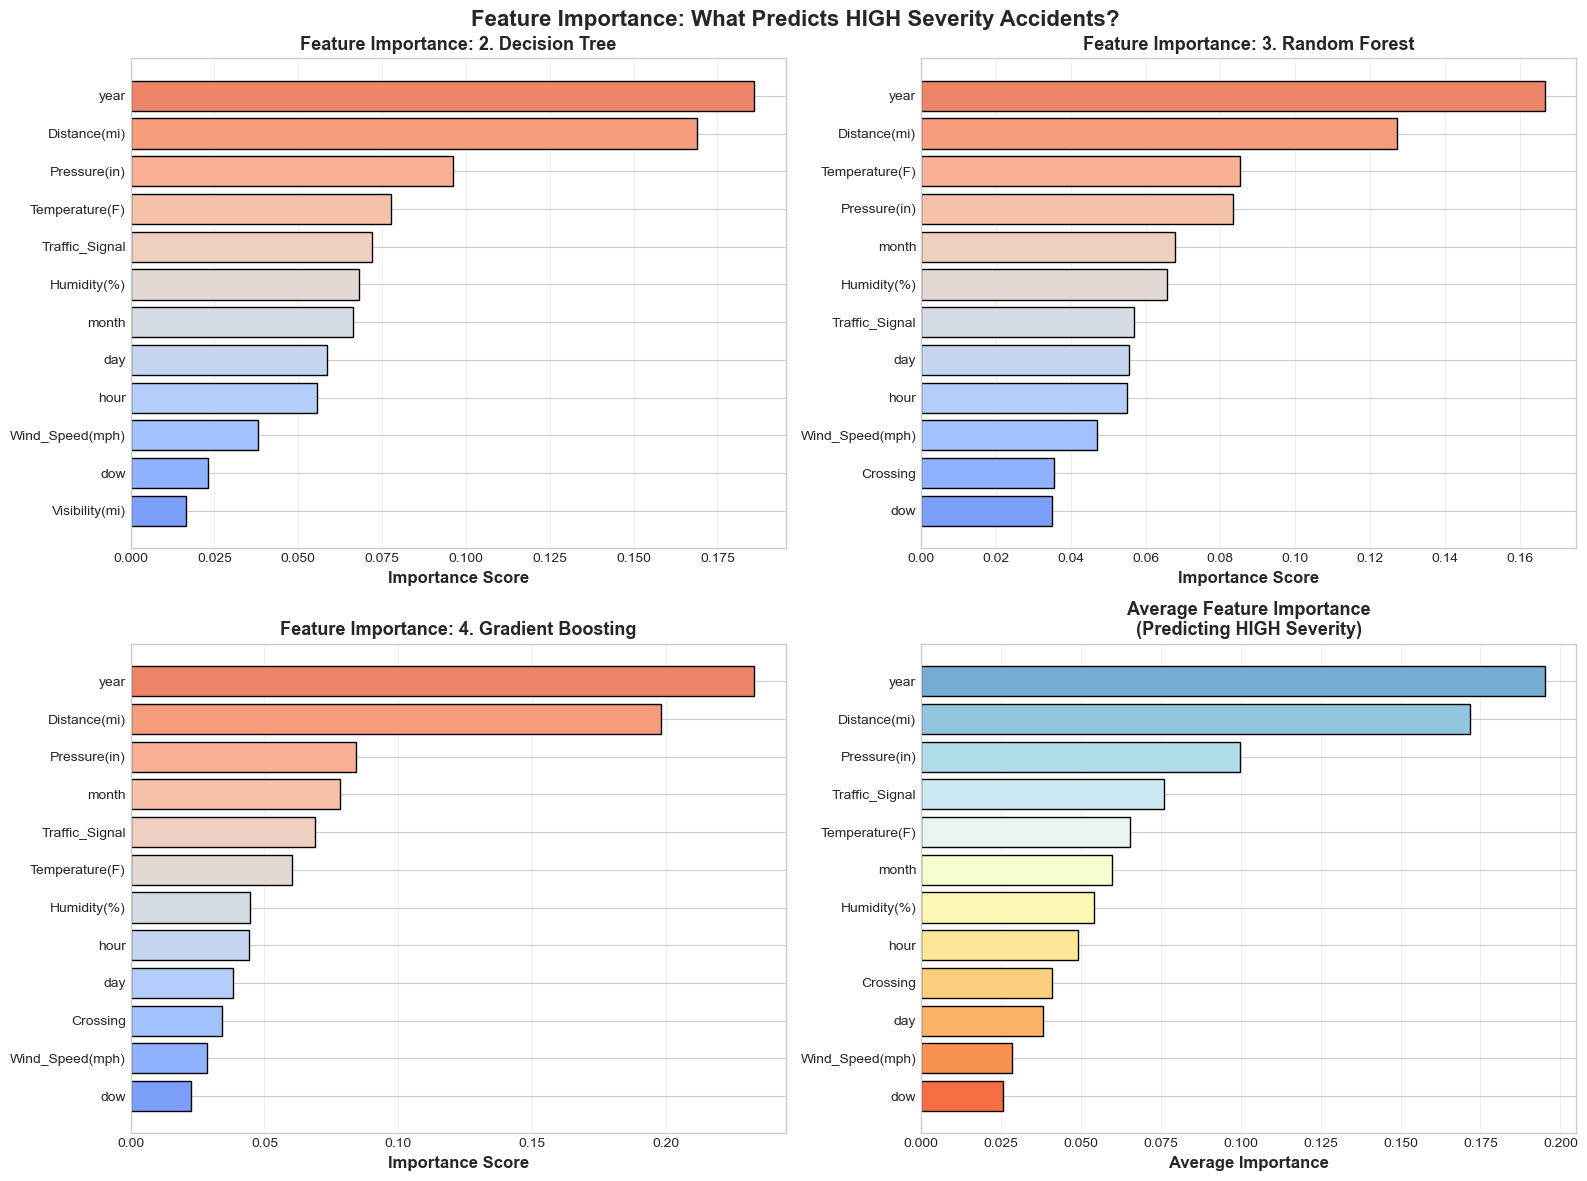

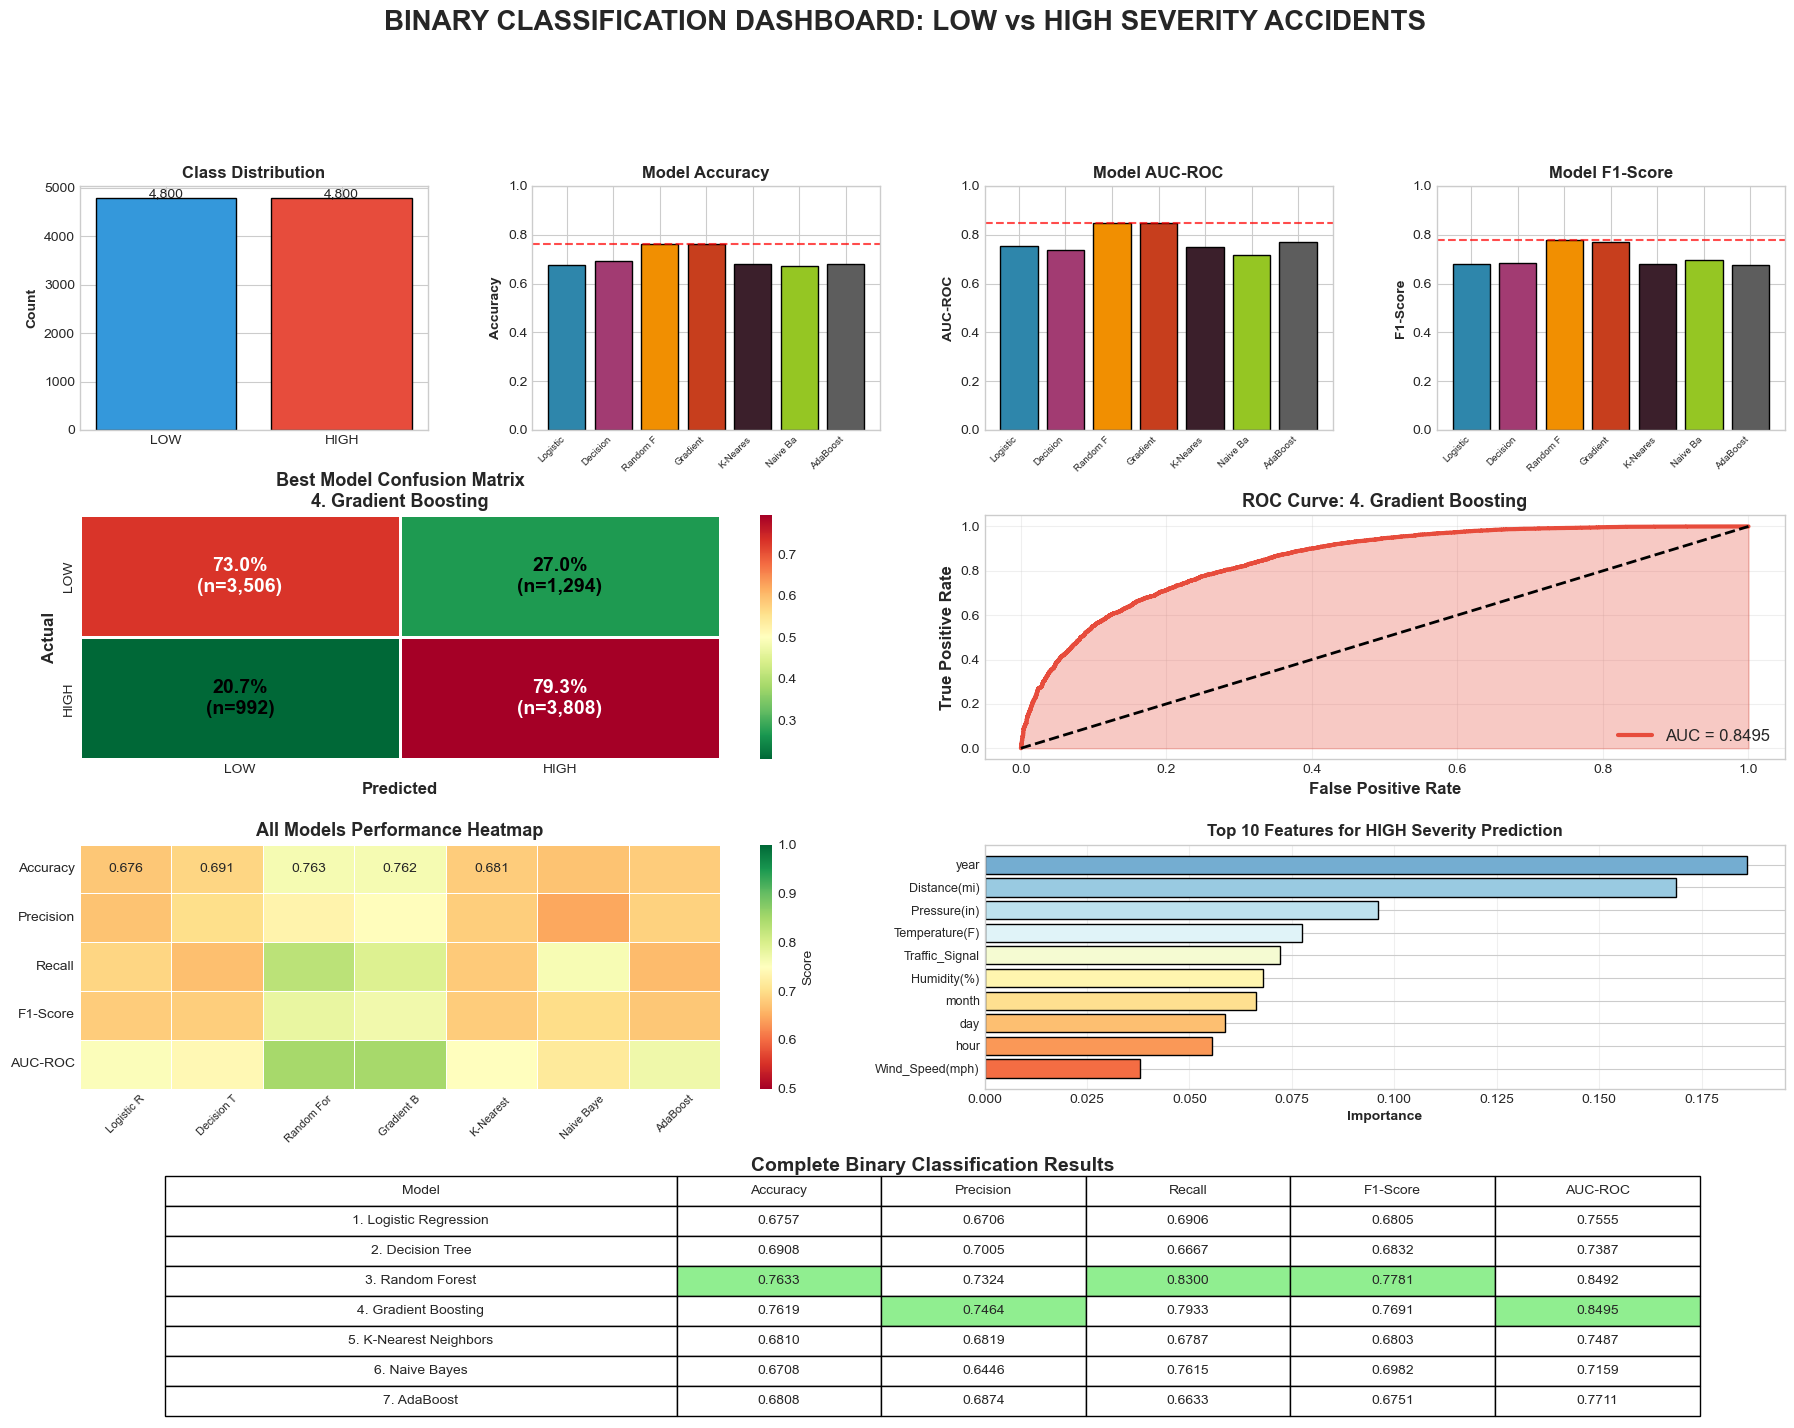


✅ Binary Classification Visualizations Complete!


In [5]:
# =============================================================================
# BINARY CLASSIFICATION VISUALIZATIONS (Add after PART 9 training completes)
# =============================================================================

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#95C623', '#5D5D5D', '#E84855']

print("\n[VISUALIZATIONS] Generating Binary Classification Plots...")

# =============================================================================
# VISUALIZATION 1: BINARY CLASS DISTRIBUTION
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original severity mapping
ax = axes[0]
original_counts = ml_df_balanced['Severity'].value_counts().sort_index()
colors_orig = ['#AED6F1', '#5DADE2', '#F5B041', '#E74C3C']
bars = ax.bar(original_counts.index, original_counts.values, color=colors_orig, edgecolor='black')
ax.set_xlabel('Original Severity', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Original 4-Class Distribution', fontsize=14, fontweight='bold')
ax.axvline(x=2.5, color='red', linestyle='--', linewidth=2, label='LOW | HIGH Split')
ax.legend()
for bar, count in zip(bars, original_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{count:,}', ha='center', fontsize=9)

# Binary distribution - Bar
ax = axes[1]
binary_counts = pd.Series(binary_y_test).value_counts().sort_index()
colors_bin = ['#3498DB', '#E74C3C']
bars = ax.bar(['LOW\n(Severity 1,2)', 'HIGH\n(Severity 3,4)'], binary_counts.values, 
              color=colors_bin, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Accidents', fontsize=12, fontweight='bold')
ax.set_title('Binary Classification Distribution', fontsize=14, fontweight='bold')
for bar, count in zip(bars, binary_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{count:,}\n({count/len(binary_y_test)*100:.1f}%)', ha='center', fontsize=11, fontweight='bold')

# Binary distribution - Pie
ax = axes[2]
ax.pie(binary_counts.values, labels=['LOW Severity\n(1,2)', 'HIGH Severity\n(3,4)'],
       colors=colors_bin, autopct='%1.1f%%', startangle=90, explode=(0.02, 0.05),
       shadow=True, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Binary Class Proportions', fontsize=14, fontweight='bold')

plt.suptitle('Binary Classification: LOW vs HIGH Severity', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 2: MODEL PERFORMANCE COMPARISON (5 Metrics)
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

binary_results_df = pd.DataFrame(binary_results).T
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    sorted_results = binary_results_df[metric].sort_values(ascending=True)
    
    bars = ax.barh(range(len(sorted_results)), sorted_results.values, 
                   color=COLORS[:len(sorted_results)], edgecolor='black', linewidth=1)
    
    ax.set_yticks(range(len(sorted_results)))
    ax.set_yticklabels(sorted_results.index, fontsize=9)
    ax.set_xlabel(f'{metric} Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Model Comparison: {metric}', fontsize=13, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(True, axis='x', alpha=0.3)
    
    for bar, val in zip(bars, sorted_results.values):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
               f'{val:.4f}', va='center', fontsize=9, fontweight='bold')

# Summary text in last subplot
ax = axes[5]
ax.axis('off')
binary_best_model = max(binary_results.keys(), key=lambda x: binary_results[x]['AUC-ROC'])
summary_text = f"""
BINARY CLASSIFICATION SUMMARY
{'='*40}

Best Model: {binary_best_model}
• Accuracy:  {binary_results[binary_best_model]['Accuracy']:.4f}
• Precision: {binary_results[binary_best_model]['Precision']:.4f}
• Recall:    {binary_results[binary_best_model]['Recall']:.4f}
• F1-Score:  {binary_results[binary_best_model]['F1-Score']:.4f}
• AUC-ROC:   {binary_results[binary_best_model]['AUC-ROC']:.4f}

{'='*40}
Classes:
• LOW (0):  Severity 1, 2 (Minor accidents)
• HIGH (1): Severity 3, 4 (Major accidents)
"""
ax.text(0.1, 0.5, summary_text, fontsize=12, fontfamily='monospace',
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.suptitle('Binary Classification: Model Performance Comparison', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 3: CONFUSION MATRICES (All Models)
# =============================================================================
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

class_labels = ['LOW', 'HIGH']

for idx, (name, y_pred) in enumerate(binary_predictions.items()):
    if idx >= 8:
        break
    ax = axes[idx]
    
    cm = confusion_matrix(binary_y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn_r', ax=ax,
                xticklabels=class_labels, yticklabels=class_labels,
                cbar=False, linewidths=2, linecolor='white',
                annot_kws={'size': 14, 'weight': 'bold'})
    
    # Add raw counts
    for i in range(2):
        for j in range(2):
            ax.text(j + 0.5, i + 0.75, f'(n={cm[i,j]:,})', ha='center', va='center', 
                   fontsize=9, color='gray')
    
    ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\nAcc: {binary_results[name]["Accuracy"]:.3f} | AUC: {binary_results[name]["AUC-ROC"]:.3f}', 
                fontsize=10, fontweight='bold')

plt.suptitle('Confusion Matrices: LOW vs HIGH Severity Classification', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 4: ROC CURVES (All Models)
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All models ROC
ax = axes[0]
for idx, (name, y_prob) in enumerate(binary_probabilities.items()):
    fpr, tpr, _ = roc_curve(binary_y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=COLORS[idx], lw=2.5, label=f'{name} (AUC={roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC=0.500)')
ax.fill_between([0, 1], [0, 1], alpha=0.1, color='gray')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('ROC Curves - All Models', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

# Best 3 models detailed
ax = axes[1]
binary_top_3 = sorted(binary_results.items(), key=lambda x: x[1]['AUC-ROC'], reverse=True)[:3]
for idx, (name, _) in enumerate(binary_top_3):
    y_prob = binary_probabilities[name]
    fpr, tpr, thresholds = roc_curve(binary_y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=COLORS[idx], lw=3, label=f'{name}\n(AUC={roc_auc:.4f})')
    ax.fill_between(fpr, tpr, alpha=0.15, color=COLORS[idx])

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('ROC Curves - Top 3 Models', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle('ROC Curve Analysis: Binary Classification', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 5: PRECISION-RECALL CURVES
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All models PR curve
ax = axes[0]
for idx, (name, y_prob) in enumerate(binary_probabilities.items()):
    precision, recall, _ = precision_recall_curve(binary_y_test, y_prob)
    ap = average_precision_score(binary_y_test, y_prob)
    ax.plot(recall, precision, color=COLORS[idx], lw=2.5, label=f'{name} (AP={ap:.3f})')

ax.set_xlabel('Recall', fontsize=14, fontweight='bold')
ax.set_ylabel('Precision', fontsize=14, fontweight='bold')
ax.set_title('Precision-Recall Curves - All Models', fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

# Top 3 models
ax = axes[1]
for idx, (name, _) in enumerate(binary_top_3):
    y_prob = binary_probabilities[name]
    precision, recall, _ = precision_recall_curve(binary_y_test, y_prob)
    ap = average_precision_score(binary_y_test, y_prob)
    ax.plot(recall, precision, color=COLORS[idx], lw=3, label=f'{name}\n(AP={ap:.4f})')
    ax.fill_between(recall, precision, alpha=0.15, color=COLORS[idx])

ax.set_xlabel('Recall', fontsize=14, fontweight='bold')
ax.set_ylabel('Precision', fontsize=14, fontweight='bold')
ax.set_title('Precision-Recall - Top 3 Models', fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.suptitle('Precision-Recall Analysis: HIGH Severity Detection', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 6: FEATURE IMPORTANCE
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Get tree-based models
binary_importance_models = {name: model for name, model in binary_models.items() 
                           if hasattr(model, 'feature_importances_')}

plot_models = list(binary_importance_models.items())[:3]

for idx, (name, model) in enumerate(plot_models):
    ax = axes[idx // 2, idx % 2]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:12]
    
    colors_imp = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(indices)))[::-1]
    
    ax.barh(range(len(indices)), importances[indices], color=colors_imp, edgecolor='black')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([binary_feature_names[i] for i in indices], fontsize=10)
    ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Feature Importance: {name}', fontsize=13, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, axis='x', alpha=0.3)

# Average importance
ax = axes[1, 1]
avg_importance = np.zeros(len(binary_feature_names))
for name, model in binary_importance_models.items():
    avg_importance += model.feature_importances_
avg_importance /= len(binary_importance_models)

indices = np.argsort(avg_importance)[::-1][:12]
colors_imp = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(indices)))

ax.barh(range(len(indices)), avg_importance[indices], color=colors_imp, edgecolor='black')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([binary_feature_names[i] for i in indices], fontsize=10)
ax.set_xlabel('Average Importance', fontsize=12, fontweight='bold')
ax.set_title('Average Feature Importance\n(Predicting HIGH Severity)', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, axis='x', alpha=0.3)

plt.suptitle('Feature Importance: What Predicts HIGH Severity Accidents?', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZATION 7: COMPREHENSIVE BINARY CLASSIFICATION DASHBOARD
# =============================================================================
fig = plt.figure(figsize=(22, 16))
gs = fig.add_gridspec(4, 4, hspace=0.35, wspace=0.3)

# 1. Binary class distribution
ax1 = fig.add_subplot(gs[0, 0])
binary_counts = pd.Series(binary_y_test).value_counts().sort_index()
bars = ax1.bar(['LOW', 'HIGH'], binary_counts.values, color=['#3498DB', '#E74C3C'], edgecolor='black')
ax1.set_ylabel('Count', fontsize=10, fontweight='bold')
ax1.set_title('Class Distribution', fontsize=12, fontweight='bold')
for bar, count in zip(bars, binary_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
            f'{count:,}', ha='center', fontsize=10)

# 2. Accuracy comparison
ax2 = fig.add_subplot(gs[0, 1])
accuracies = [binary_results[m]['Accuracy'] for m in binary_models.keys()]
model_short = [m.split('. ')[1][:8] for m in binary_models.keys()]
bars = ax2.bar(range(len(binary_models)), accuracies, color=COLORS, edgecolor='black')
ax2.set_xticks(range(len(binary_models)))
ax2.set_xticklabels(model_short, rotation=45, ha='right', fontsize=7)
ax2.set_ylabel('Accuracy', fontsize=10, fontweight='bold')
ax2.set_title('Model Accuracy', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.axhline(y=max(accuracies), color='red', linestyle='--', alpha=0.7)

# 3. AUC-ROC comparison
ax3 = fig.add_subplot(gs[0, 2])
aucs = [binary_results[m]['AUC-ROC'] for m in binary_models.keys()]
bars = ax3.bar(range(len(binary_models)), aucs, color=COLORS, edgecolor='black')
ax3.set_xticks(range(len(binary_models)))
ax3.set_xticklabels(model_short, rotation=45, ha='right', fontsize=7)
ax3.set_ylabel('AUC-ROC', fontsize=10, fontweight='bold')
ax3.set_title('Model AUC-ROC', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 1)
ax3.axhline(y=max(aucs), color='red', linestyle='--', alpha=0.7)

# 4. F1-Score comparison
ax4 = fig.add_subplot(gs[0, 3])
f1s = [binary_results[m]['F1-Score'] for m in binary_models.keys()]
bars = ax4.bar(range(len(binary_models)), f1s, color=COLORS, edgecolor='black')
ax4.set_xticks(range(len(binary_models)))
ax4.set_xticklabels(model_short, rotation=45, ha='right', fontsize=7)
ax4.set_ylabel('F1-Score', fontsize=10, fontweight='bold')
ax4.set_title('Model F1-Score', fontsize=12, fontweight='bold')
ax4.set_ylim(0, 1)
ax4.axhline(y=max(f1s), color='red', linestyle='--', alpha=0.7)

# 5. Best model confusion matrix
ax5 = fig.add_subplot(gs[1, 0:2])
cm = confusion_matrix(binary_y_test, binary_predictions[binary_best_model])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_norm, annot=False, cmap='RdYlGn_r', ax=ax5,
            xticklabels=['LOW', 'HIGH'], yticklabels=['LOW', 'HIGH'],
            linewidths=2, linecolor='white')

for i in range(2):
    for j in range(2):
        text = f'{cm_norm[i,j]:.1%}\n(n={cm[i,j]:,})'
        color = 'white' if cm_norm[i,j] > 0.5 else 'black'
        ax5.text(j + 0.5, i + 0.5, text, ha='center', va='center', 
                fontsize=14, fontweight='bold', color=color)

ax5.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax5.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax5.set_title(f'Best Model Confusion Matrix\n{binary_best_model}', fontsize=13, fontweight='bold')

# 6. ROC curve for best model
ax6 = fig.add_subplot(gs[1, 2:4])
y_prob_best = binary_probabilities[binary_best_model]
fpr, tpr, _ = roc_curve(binary_y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

ax6.plot(fpr, tpr, color='#E74C3C', lw=3, label=f'AUC = {roc_auc:.4f}')
ax6.fill_between(fpr, tpr, alpha=0.3, color='#E74C3C')
ax6.plot([0, 1], [0, 1], 'k--', lw=2)
ax6.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax6.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax6.set_title(f'ROC Curve: {binary_best_model}', fontsize=13, fontweight='bold')
ax6.legend(loc='lower right', fontsize=12)
ax6.grid(True, alpha=0.3)

# 7. Performance Heatmap
ax7 = fig.add_subplot(gs[2, 0:2])
heatmap_data = binary_results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']]
model_labels = [m.split('. ')[1][:10] for m in heatmap_data.index]
sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax7,
            xticklabels=model_labels, yticklabels=heatmap_data.columns,
            cbar_kws={'label': 'Score'}, vmin=0.5, vmax=1.0, linewidths=0.5)
ax7.set_xlabel('')
ax7.set_ylabel('')
ax7.set_title('All Models Performance Heatmap', fontsize=13, fontweight='bold')
ax7.tick_params(axis='x', rotation=45, labelsize=8)
ax7.tick_params(axis='y', rotation=0, labelsize=10)

# 8. Feature importance
ax8 = fig.add_subplot(gs[2, 2:4])
if binary_importance_models:
    best_tree = list(binary_importance_models.values())[0]
    importances = best_tree.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    
    ax8.barh(range(10), importances[indices], 
             color=plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, 10)), edgecolor='black')
    ax8.set_yticks(range(10))
    ax8.set_yticklabels([binary_feature_names[i] for i in indices], fontsize=9)
    ax8.invert_yaxis()
    ax8.set_xlabel('Importance', fontsize=10, fontweight='bold')
    ax8.set_title('Top 10 Features for HIGH Severity Prediction', fontsize=12, fontweight='bold')
    ax8.grid(True, axis='x', alpha=0.3)

# 9. Results table
ax9 = fig.add_subplot(gs[3, :])
ax9.axis('off')

table_data = []
for model in binary_models.keys():
    row = [model, 
           f"{binary_results[model]['Accuracy']:.4f}",
           f"{binary_results[model]['Precision']:.4f}",
           f"{binary_results[model]['Recall']:.4f}",
           f"{binary_results[model]['F1-Score']:.4f}",
           f"{binary_results[model]['AUC-ROC']:.4f}"]
    table_data.append(row)

table = ax9.table(cellText=table_data,
                  colLabels=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
                  cellLoc='center', loc='center',
                  colWidths=[0.25, 0.1, 0.1, 0.1, 0.1, 0.1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.8)

# Highlight best values
for i, model in enumerate(binary_models.keys()):
    for j, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']):
        max_val = max([binary_results[m][metric] for m in binary_models.keys()])
        if binary_results[model][metric] == max_val:
            table[(i+1, j+1)].set_facecolor('#90EE90')

ax9.set_title('Complete Binary Classification Results', fontsize=14, fontweight='bold', y=0.98)

plt.suptitle('BINARY CLASSIFICATION DASHBOARD: LOW vs HIGH SEVERITY ACCIDENTS', 
             fontsize=20, fontweight='bold', y=0.99)
plt.tight_layout()
plt.show()

print("\n✅ Binary Classification Visualizations Complete!")


## EXPORT MULTI-CLASS ML RESULTS FOR TABLEAU

In [6]:
# =============================================================================
# EXPORT MULTI-CLASS ML RESULTS FOR TABLEAU
# =============================================================================
# Run this AFTER PART 8 (Multi-class training) completes
# Creates CSV files optimized for Tableau visualizations
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import label_binarize
import os

print("=" * 70)
print("EXPORTING MULTI-CLASS DATA FOR TABLEAU")
print("=" * 70)

# Create output directory
output_dir = 'tableau_multiclass'
os.makedirs(output_dir, exist_ok=True)

# =============================================================================
# 1. MODEL PERFORMANCE DATA
# =============================================================================
print("\n[1] Exporting Model Performance Data...")

performance_data = []
for model_name, metrics in multiclass_results.items():
    model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
    for metric_name, value in metrics.items():
        performance_data.append({
            'Model': model_short,
            'Metric': metric_name,
            'Value': round(value, 4)
        })

performance_df = pd.DataFrame(performance_data)
performance_df.to_csv(f'{output_dir}/1_multiclass_performance.csv', index=False)
print(f"  ✓ Saved: 1_multiclass_performance.csv ({len(performance_df)} rows)")

# =============================================================================
# 2. CONFUSION MATRIX DATA
# =============================================================================
print("\n[2] Exporting Confusion Matrix Data...")

confusion_data = []
n_classes = len(label_encoder.classes_)
class_labels = [f'Sev_{c}' for c in label_encoder.classes_]

for model_name, y_pred in multiclass_predictions.items():
    cm = confusion_matrix(multiclass_y_test, y_pred)
    model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
    
    for actual in range(n_classes):
        for predicted in range(n_classes):
            confusion_data.append({
                'Model': model_short,
                'Actual': class_labels[actual],
                'Predicted': class_labels[predicted],
                'Count': int(cm[actual, predicted]),
                'Percentage': round(cm[actual, predicted] / cm[actual].sum() * 100, 2)
            })

confusion_df = pd.DataFrame(confusion_data)
confusion_df.to_csv(f'{output_dir}/2_multiclass_confusion.csv', index=False)
print(f"  ✓ Saved: 2_multiclass_confusion.csv ({len(confusion_df)} rows)")

# =============================================================================
# 3. ROC CURVE DATA (Macro-Average)
# =============================================================================
print("\n[3] Exporting ROC Curve Data...")

roc_data = []
POINTS_PER_MODEL = 50
classes = list(range(n_classes))
multiclass_y_test_bin = label_binarize(multiclass_y_test, classes=classes)

for model_name, y_prob in multiclass_probabilities.items():
    model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
    
    # Calculate macro-average ROC
    all_fpr = np.linspace(0, 1, POINTS_PER_MODEL)
    mean_tpr = np.zeros(POINTS_PER_MODEL)
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(multiclass_y_test_bin[:, i], y_prob[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= n_classes
    
    for j in range(POINTS_PER_MODEL):
        roc_data.append({
            'Model': model_short,
            'FPR': round(all_fpr[j], 4),
            'TPR': round(mean_tpr[j], 4)
        })

# Add random classifier line
for i in range(11):
    roc_data.append({
        'Model': 'Random',
        'FPR': round(i/10, 1),
        'TPR': round(i/10, 1)
    })

roc_df = pd.DataFrame(roc_data)
roc_df.to_csv(f'{output_dir}/3_multiclass_roc.csv', index=False)
print(f"  ✓ Saved: 3_multiclass_roc.csv ({len(roc_df)} rows)")

# =============================================================================
# 4. FEATURE IMPORTANCE DATA
# =============================================================================
print("\n[4] Exporting Feature Importance Data...")

importance_data = []
TOP_N = 15

for model_name, model in multiclass_models.items():
    if hasattr(model, 'feature_importances_'):
        model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:TOP_N]
        
        for rank, idx in enumerate(indices, 1):
            importance_data.append({
                'Model': model_short,
                'Feature': multiclass_feature_names[idx],
                'Importance': round(importances[idx], 4),
                'Rank': rank
            })

# Calculate average importance
avg_importance = np.zeros(len(multiclass_feature_names))
tree_count = 0
for model_name, model in multiclass_models.items():
    if hasattr(model, 'feature_importances_'):
        avg_importance += model.feature_importances_
        tree_count += 1

if tree_count > 0:
    avg_importance /= tree_count
    indices = np.argsort(avg_importance)[::-1][:TOP_N]
    for rank, idx in enumerate(indices, 1):
        importance_data.append({
            'Model': 'Average',
            'Feature': multiclass_feature_names[idx],
            'Importance': round(avg_importance[idx], 4),
            'Rank': rank
        })

importance_df = pd.DataFrame(importance_data)
importance_df.to_csv(f'{output_dir}/4_multiclass_importance.csv', index=False)
print(f"  ✓ Saved: 4_multiclass_importance.csv ({len(importance_df)} rows)")

# =============================================================================
# 5. CLASS DISTRIBUTION DATA
# =============================================================================
print("\n[5] Exporting Class Distribution Data...")

dist_data = []

# Actual distribution
actual_counts = np.bincount(multiclass_y_test, minlength=n_classes)
for i, count in enumerate(actual_counts):
    dist_data.append({
        'Source': 'Actual',
        'Class': class_labels[i],
        'Count': int(count),
        'Percentage': round(count / len(multiclass_y_test) * 100, 2)
    })

# Predicted distribution for each model
for model_name, y_pred in multiclass_predictions.items():
    model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
    pred_counts = np.bincount(y_pred, minlength=n_classes)
    
    for i, count in enumerate(pred_counts):
        dist_data.append({
            'Source': model_short,
            'Class': class_labels[i],
            'Count': int(count),
            'Percentage': round(count / len(y_pred) * 100, 2)
        })

dist_df = pd.DataFrame(dist_data)
dist_df.to_csv(f'{output_dir}/5_multiclass_distribution.csv', index=False)
print(f"  ✓ Saved: 5_multiclass_distribution.csv ({len(dist_df)} rows)")

# =============================================================================
# 6. MODEL SUMMARY TABLE
# =============================================================================
print("\n[6] Exporting Model Summary...")

summary_data = []
for model_name, metrics in multiclass_results.items():
    model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
    summary_data.append({
        'Model': model_short,
        'Accuracy': round(metrics['Accuracy'], 4),
        'Precision': round(metrics['Precision'], 4),
        'Recall': round(metrics['Recall'], 4),
        'F1_Score': round(metrics['F1-Score'], 4)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Accuracy', ascending=False)
summary_df['Rank'] = range(1, len(summary_df) + 1)
summary_df.to_csv(f'{output_dir}/6_multiclass_summary.csv', index=False)
print(f"  ✓ Saved: 6_multiclass_summary.csv ({len(summary_df)} rows)")

# =============================================================================
# 7. SAMPLE PREDICTIONS
# =============================================================================
print("\n[7] Exporting Sample Predictions...")

SAMPLE_SIZE = 1000
np.random.seed(42)
sample_indices = np.random.choice(len(multiclass_y_test), min(SAMPLE_SIZE, len(multiclass_y_test)), replace=False)

best_model = max(multiclass_results.keys(), key=lambda x: multiclass_results[x]['Accuracy'])
best_model_short = best_model.split('. ')[1] if '. ' in best_model else best_model

sample_data = {
    'Index': sample_indices,
    'Actual': multiclass_y_test[sample_indices],
    'Actual_Label': [class_labels[y] for y in multiclass_y_test[sample_indices]],
    'Predicted': multiclass_predictions[best_model][sample_indices],
    'Predicted_Label': [class_labels[y] for y in multiclass_predictions[best_model][sample_indices]],
    'Correct': (multiclass_y_test[sample_indices] == multiclass_predictions[best_model][sample_indices]).astype(int)
}

sample_df = pd.DataFrame(sample_data)
sample_df.to_csv(f'{output_dir}/7_multiclass_samples.csv', index=False)
print(f"  ✓ Saved: 7_multiclass_samples.csv ({len(sample_df)} rows)")

# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "=" * 70)
print("✅ MULTI-CLASS TABLEAU EXPORT COMPLETE!")
print("=" * 70)

print(f"\n📁 Files saved in: '{output_dir}/' folder")
print("\n📊 CSV FILES CREATED:")
print("-" * 50)

files_created = [
    ("1_multiclass_performance.csv", "Bar chart: Model metrics comparison"),
    ("2_multiclass_confusion.csv", "Heatmap: Confusion matrix per model"),
    ("3_multiclass_roc.csv", "Line chart: ROC curves (macro-average)"),
    ("4_multiclass_importance.csv", "Bar chart: Top 15 features per model"),
    ("5_multiclass_distribution.csv", "Bar chart: Actual vs Predicted"),
    ("6_multiclass_summary.csv", "Table: Quick model comparison"),
    ("7_multiclass_samples.csv", "Detail: Sample predictions"),
]

for filename, description in files_created:
    filepath = f'{output_dir}/{filename}'
    if os.path.exists(filepath):
        size = os.path.getsize(filepath)
        print(f"  📄 {filename} ({size/1024:.1f} KB)")
        print(f"     → {description}")

print("\n" + "=" * 70)


EXPORTING MULTI-CLASS DATA FOR TABLEAU

[1] Exporting Model Performance Data...
  ✓ Saved: 1_multiclass_performance.csv (28 rows)

[2] Exporting Confusion Matrix Data...
  ✓ Saved: 2_multiclass_confusion.csv (112 rows)

[3] Exporting ROC Curve Data...
  ✓ Saved: 3_multiclass_roc.csv (361 rows)

[4] Exporting Feature Importance Data...
  ✓ Saved: 4_multiclass_importance.csv (90 rows)

[5] Exporting Class Distribution Data...
  ✓ Saved: 5_multiclass_distribution.csv (32 rows)

[6] Exporting Model Summary...
  ✓ Saved: 6_multiclass_summary.csv (7 rows)

[7] Exporting Sample Predictions...
  ✓ Saved: 7_multiclass_samples.csv (1000 rows)

✅ MULTI-CLASS TABLEAU EXPORT COMPLETE!

📁 Files saved in: 'tableau_multiclass/' folder

📊 CSV FILES CREATED:
--------------------------------------------------
  📄 1_multiclass_performance.csv (0.9 KB)
     → Bar chart: Model metrics comparison
  📄 2_multiclass_confusion.csv (4.2 KB)
     → Heatmap: Confusion matrix per model
  📄 3_multiclass_roc.csv (10.5

## EXPORT BINARY ML RESULTS FOR TABLEAU

In [7]:
# =============================================================================
# EXPORT BINARY ML RESULTS FOR TABLEAU
# =============================================================================
# Run this AFTER PART 9 (Binary training) completes
# Creates CSV files optimized for Tableau visualizations
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
import os

print("=" * 70)
print("EXPORTING BINARY CLASSIFICATION DATA FOR TABLEAU")
print("=" * 70)

# Create output directory
output_dir = 'tableau_binary'
os.makedirs(output_dir, exist_ok=True)

# =============================================================================
# 1. MODEL PERFORMANCE DATA (5 Metrics including AUC-ROC)
# =============================================================================
print("\n[1] Exporting Model Performance Data...")

performance_data = []
for model_name, metrics in binary_results.items():
    model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
    for metric_name, value in metrics.items():
        performance_data.append({
            'Model': model_short,
            'Metric': metric_name,
            'Value': round(value, 4)
        })

performance_df = pd.DataFrame(performance_data)
performance_df.to_csv(f'{output_dir}/1_binary_performance.csv', index=False)
print(f"  ✓ Saved: 1_binary_performance.csv ({len(performance_df)} rows)")

# =============================================================================
# 2. CONFUSION MATRIX DATA
# =============================================================================
print("\n[2] Exporting Confusion Matrix Data...")

confusion_data = []
class_labels = ['LOW', 'HIGH']

for model_name, y_pred in binary_predictions.items():
    cm = confusion_matrix(binary_y_test, y_pred)
    model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
    
    for actual in range(2):
        for predicted in range(2):
            confusion_data.append({
                'Model': model_short,
                'Actual': class_labels[actual],
                'Predicted': class_labels[predicted],
                'Count': int(cm[actual, predicted]),
                'Percentage': round(cm[actual, predicted] / cm[actual].sum() * 100, 2),
                'Cell_Type': 'TN' if (actual==0 and predicted==0) else 
                            'FP' if (actual==0 and predicted==1) else
                            'FN' if (actual==1 and predicted==0) else 'TP'
            })

confusion_df = pd.DataFrame(confusion_data)
confusion_df.to_csv(f'{output_dir}/2_binary_confusion.csv', index=False)
print(f"  ✓ Saved: 2_binary_confusion.csv ({len(confusion_df)} rows)")

# =============================================================================
# 3. ROC CURVE DATA
# =============================================================================
print("\n[3] Exporting ROC Curve Data...")

roc_data = []
POINTS_PER_MODEL = 50

for model_name, y_prob in binary_probabilities.items():
    model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
    
    fpr, tpr, thresholds = roc_curve(binary_y_test, y_prob)
    
    # Sample to POINTS_PER_MODEL points
    if len(fpr) > POINTS_PER_MODEL:
        indices = np.linspace(0, len(fpr)-1, POINTS_PER_MODEL, dtype=int)
        fpr_sampled = fpr[indices]
        tpr_sampled = tpr[indices]
        thresh_sampled = thresholds[indices]
    else:
        fpr_sampled = fpr
        tpr_sampled = tpr
        thresh_sampled = thresholds
    
    for j in range(len(fpr_sampled)):
        roc_data.append({
            'Model': model_short,
            'FPR': round(fpr_sampled[j], 4),
            'TPR': round(tpr_sampled[j], 4),
            'Threshold': round(thresh_sampled[j], 4) if j < len(thresh_sampled) else 0
        })

# Add random classifier line
for i in range(11):
    roc_data.append({
        'Model': 'Random',
        'FPR': round(i/10, 1),
        'TPR': round(i/10, 1),
        'Threshold': 0.5
    })

roc_df = pd.DataFrame(roc_data)
roc_df.to_csv(f'{output_dir}/3_binary_roc.csv', index=False)
print(f"  ✓ Saved: 3_binary_roc.csv ({len(roc_df)} rows)")

# =============================================================================
# 4. PRECISION-RECALL CURVE DATA
# =============================================================================
print("\n[4] Exporting Precision-Recall Curve Data...")

pr_data = []
POINTS_PER_MODEL = 50

for model_name, y_prob in binary_probabilities.items():
    model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
    
    precision, recall, thresholds = precision_recall_curve(binary_y_test, y_prob)
    
    # Sample points
    if len(precision) > POINTS_PER_MODEL:
        indices = np.linspace(0, len(precision)-1, POINTS_PER_MODEL, dtype=int)
        precision = precision[indices]
        recall = recall[indices]
    
    for j in range(len(precision)):
        pr_data.append({
            'Model': model_short,
            'Precision': round(precision[j], 4),
            'Recall': round(recall[j], 4)
        })

pr_df = pd.DataFrame(pr_data)
pr_df.to_csv(f'{output_dir}/4_binary_precision_recall.csv', index=False)
print(f"  ✓ Saved: 4_binary_precision_recall.csv ({len(pr_df)} rows)")

# =============================================================================
# 5. FEATURE IMPORTANCE DATA
# =============================================================================
print("\n[5] Exporting Feature Importance Data...")

importance_data = []
TOP_N = 15

for model_name, model in binary_models.items():
    if hasattr(model, 'feature_importances_'):
        model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:TOP_N]
        
        for rank, idx in enumerate(indices, 1):
            importance_data.append({
                'Model': model_short,
                'Feature': binary_feature_names[idx],
                'Importance': round(importances[idx], 4),
                'Rank': rank
            })

# Calculate average importance
avg_importance = np.zeros(len(binary_feature_names))
tree_count = 0
for model_name, model in binary_models.items():
    if hasattr(model, 'feature_importances_'):
        avg_importance += model.feature_importances_
        tree_count += 1

if tree_count > 0:
    avg_importance /= tree_count
    indices = np.argsort(avg_importance)[::-1][:TOP_N]
    for rank, idx in enumerate(indices, 1):
        importance_data.append({
            'Model': 'Average',
            'Feature': binary_feature_names[idx],
            'Importance': round(avg_importance[idx], 4),
            'Rank': rank
        })

importance_df = pd.DataFrame(importance_data)
importance_df.to_csv(f'{output_dir}/5_binary_importance.csv', index=False)
print(f"  ✓ Saved: 5_binary_importance.csv ({len(importance_df)} rows)")

# =============================================================================
# 6. CLASS DISTRIBUTION DATA
# =============================================================================
print("\n[6] Exporting Class Distribution Data...")

dist_data = []

# Actual distribution
for cls in [0, 1]:
    count = (binary_y_test == cls).sum()
    dist_data.append({
        'Source': 'Actual',
        'Class': class_labels[cls],
        'Count': int(count),
        'Percentage': round(count / len(binary_y_test) * 100, 2)
    })

# Predicted distribution for each model
for model_name, y_pred in binary_predictions.items():
    model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
    
    for cls in [0, 1]:
        count = (y_pred == cls).sum()
        dist_data.append({
            'Source': model_short,
            'Class': class_labels[cls],
            'Count': int(count),
            'Percentage': round(count / len(y_pred) * 100, 2)
        })

dist_df = pd.DataFrame(dist_data)
dist_df.to_csv(f'{output_dir}/6_binary_distribution.csv', index=False)
print(f"  ✓ Saved: 6_binary_distribution.csv ({len(dist_df)} rows)")

# =============================================================================
# 7. MODEL SUMMARY TABLE
# =============================================================================
print("\n[7] Exporting Model Summary...")

summary_data = []
for model_name, metrics in binary_results.items():
    model_short = model_name.split('. ')[1] if '. ' in model_name else model_name
    summary_data.append({
        'Model': model_short,
        'Accuracy': round(metrics['Accuracy'], 4),
        'Precision': round(metrics['Precision'], 4),
        'Recall': round(metrics['Recall'], 4),
        'F1_Score': round(metrics['F1-Score'], 4),
        'AUC_ROC': round(metrics['AUC-ROC'], 4)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('AUC_ROC', ascending=False)
summary_df['Rank'] = range(1, len(summary_df) + 1)
summary_df.to_csv(f'{output_dir}/7_binary_summary.csv', index=False)
print(f"  ✓ Saved: 7_binary_summary.csv ({len(summary_df)} rows)")

# =============================================================================
# 8. SAMPLE PREDICTIONS WITH PROBABILITIES
# =============================================================================
print("\n[8] Exporting Sample Predictions...")

SAMPLE_SIZE = 1000
np.random.seed(42)

# Convert to array if needed
if hasattr(binary_y_test, 'values'):
    y_test_arr = binary_y_test.values
else:
    y_test_arr = np.array(binary_y_test)

sample_indices = np.random.choice(len(y_test_arr), min(SAMPLE_SIZE, len(y_test_arr)), replace=False)

best_model = max(binary_results.keys(), key=lambda x: binary_results[x]['AUC-ROC'])
best_model_short = best_model.split('. ')[1] if '. ' in best_model else best_model

sample_data = {
    'Index': sample_indices,
    'Actual': y_test_arr[sample_indices],
    'Actual_Label': [class_labels[int(y)] for y in y_test_arr[sample_indices]],
    'Predicted': binary_predictions[best_model][sample_indices],
    'Predicted_Label': [class_labels[int(y)] for y in binary_predictions[best_model][sample_indices]],
    'Prob_HIGH': np.round(binary_probabilities[best_model][sample_indices], 4),
    'Correct': (y_test_arr[sample_indices] == binary_predictions[best_model][sample_indices]).astype(int)
}

sample_df = pd.DataFrame(sample_data)
sample_df.to_csv(f'{output_dir}/8_binary_samples.csv', index=False)
print(f"  ✓ Saved: 8_binary_samples.csv ({len(sample_df)} rows)")

# =============================================================================
# 9. THRESHOLD ANALYSIS DATA
# =============================================================================
print("\n[9] Exporting Threshold Analysis Data...")

threshold_data = []
best_prob = binary_probabilities[best_model]

for threshold in np.arange(0.1, 1.0, 0.05):
    y_pred_thresh = (best_prob >= threshold).astype(int)
    
    tp = ((y_pred_thresh == 1) & (y_test_arr == 1)).sum()
    tn = ((y_pred_thresh == 0) & (y_test_arr == 0)).sum()
    fp = ((y_pred_thresh == 1) & (y_test_arr == 0)).sum()
    fn = ((y_pred_thresh == 0) & (y_test_arr == 1)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / len(y_test_arr)
    
    threshold_data.append({
        'Threshold': round(threshold, 2),
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1_Score': round(f1, 4),
        'TP': int(tp),
        'TN': int(tn),
        'FP': int(fp),
        'FN': int(fn)
    })

threshold_df = pd.DataFrame(threshold_data)
threshold_df.to_csv(f'{output_dir}/9_threshold_analysis.csv', index=False)
print(f"  ✓ Saved: 9_threshold_analysis.csv ({len(threshold_df)} rows)")

# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "=" * 70)
print("✅ BINARY CLASSIFICATION TABLEAU EXPORT COMPLETE!")
print("=" * 70)

print(f"\n📁 Files saved in: '{output_dir}/' folder")
print("\n📊 CSV FILES CREATED:")
print("-" * 50)

files_created = [
    ("1_binary_performance.csv", "Bar chart: Model metrics (5 metrics)"),
    ("2_binary_confusion.csv", "Heatmap: Confusion matrix per model"),
    ("3_binary_roc.csv", "Line chart: ROC curves"),
    ("4_binary_precision_recall.csv", "Line chart: PR curves"),
    ("5_binary_importance.csv", "Bar chart: Top 15 features"),
    ("6_binary_distribution.csv", "Bar chart: LOW vs HIGH counts"),
    ("7_binary_summary.csv", "Table: Model rankings"),
    ("8_binary_samples.csv", "Detail: Predictions with probabilities"),
    ("9_threshold_analysis.csv", "Line chart: Threshold optimization"),
]

total_size = 0
for filename, description in files_created:
    filepath = f'{output_dir}/{filename}'
    if os.path.exists(filepath):
        size = os.path.getsize(filepath)
        total_size += size
        print(f"  📄 {filename} ({size/1024:.1f} KB)")
        print(f"     → {description}")

print(f"\n📦 Total size: {total_size/1024:.1f} KB")

# =============================================================================
# TABLEAU QUICK START GUIDE
# =============================================================================
print("\n" + "=" * 70)
print("🎯 TABLEAU VISUALIZATION GUIDE")
print("=" * 70)
print("""
MULTI-CLASS VISUALIZATIONS:
─────────────────────────────────────────
1. Model Performance Bar Chart
   Data: 1_multiclass_performance.csv
   Columns: Model | Rows: Value | Color: Metric

2. Confusion Matrix Heatmap
   Data: 2_multiclass_confusion.csv
   Columns: Predicted | Rows: Actual | Color: Percentage
   Filter: Model (dropdown)

3. ROC Curves (Macro-Average)
   Data: 3_multiclass_roc.csv
   Columns: FPR | Rows: TPR | Color: Model
   Mark: Line

4. Feature Importance
   Data: 4_multiclass_importance.csv
   Rows: Feature | Columns: Importance
   Filter: Model, Rank <= 10

5. Class Distribution
   Data: 5_multiclass_distribution.csv
   Columns: Class | Rows: Count | Color: Source

BINARY CLASSIFICATION VISUALIZATIONS:
─────────────────────────────────────────
1. Performance Comparison (5 Metrics)
   Data: 1_binary_performance.csv
   Create small multiples by Metric

2. Confusion Matrix
   Data: 2_binary_confusion.csv
   Use Cell_Type for conditional formatting

3. ROC Curves
   Data: 3_binary_roc.csv
   Add diagonal reference line

4. Precision-Recall Curves
   Data: 4_binary_precision_recall.csv
   Great for imbalanced classes

5. Threshold Analysis
   Data: 9_threshold_analysis.csv
   Interactive: Show how metrics change with threshold

DASHBOARD TIPS:
─────────────────────────────────────────
• Use Model as a global filter
• Add parameter for threshold selection (binary)
• Include KPI cards for best model metrics
• Use consistent color scheme across sheets
""")
print("=" * 70)


EXPORTING BINARY CLASSIFICATION DATA FOR TABLEAU

[1] Exporting Model Performance Data...
  ✓ Saved: 1_binary_performance.csv (35 rows)

[2] Exporting Confusion Matrix Data...
  ✓ Saved: 2_binary_confusion.csv (28 rows)

[3] Exporting ROC Curve Data...
  ✓ Saved: 3_binary_roc.csv (361 rows)

[4] Exporting Precision-Recall Curve Data...
  ✓ Saved: 4_binary_precision_recall.csv (350 rows)

[5] Exporting Feature Importance Data...
  ✓ Saved: 5_binary_importance.csv (75 rows)

[6] Exporting Class Distribution Data...
  ✓ Saved: 6_binary_distribution.csv (16 rows)

[7] Exporting Model Summary...
  ✓ Saved: 7_binary_summary.csv (7 rows)

[8] Exporting Sample Predictions...
  ✓ Saved: 8_binary_samples.csv (1000 rows)

[9] Exporting Threshold Analysis Data...
  ✓ Saved: 9_threshold_analysis.csv (18 rows)

✅ BINARY CLASSIFICATION TABLEAU EXPORT COMPLETE!

📁 Files saved in: 'tableau_binary/' folder

📊 CSV FILES CREATED:
--------------------------------------------------
  📄 1_binary_performance.

In [8]:
# =============================================================================
# SAVE MODELS FOR STREAMLIT APP (BOTH BINARY & MULTI-CLASS)
# =============================================================================
# Run this AFTER training both multi-class and binary models
# =============================================================================

import pickle
import os

print("=" * 70)
print("SAVING ALL MODELS FOR STREAMLIT APP")
print("=" * 70)

# =============================================================================
# CREATE DIRECTORIES
# =============================================================================
os.makedirs('models/multiclass', exist_ok=True)
os.makedirs('models/binary', exist_ok=True)
print("\n✓ Created 'models/multiclass/' and 'models/binary/' directories")

# =============================================================================
# SAVE MULTI-CLASS MODELS
# =============================================================================
print("\n" + "=" * 50)
print("[1] SAVING MULTI-CLASS MODELS")
print("=" * 50)

# Check if multiclass variables exist
multiclass_vars = ['multiclass_models', 'multiclass_scaler', 'multiclass_feature_names']
multiclass_exists = all(var in globals() or var in dir() for var in multiclass_vars)

if 'multiclass_models' in globals():
    print("\nSaving multi-class models...")
    saved_count = 0
    
    for name, model in multiclass_models.items():
        try:
            filename = name.replace('. ', '_').replace(' ', '_').lower()
            filepath = f'models/multiclass/{filename}.pkl'
            
            with open(filepath, 'wb') as f:
                pickle.dump(model, f)
            
            print(f"  ✓ Saved: {filename}.pkl")
            saved_count += 1
        except Exception as e:
            print(f"  ✗ Error saving {name}: {e}")
    
    # Save scaler
    try:
        with open('models/multiclass/scaler.pkl', 'wb') as f:
            pickle.dump(multiclass_scaler, f)
        print(f"  ✓ Saved: scaler.pkl")
    except Exception as e:
        print(f"  ✗ Error saving scaler: {e}")
    
    # Save feature names
    try:
        with open('models/multiclass/feature_names.pkl', 'wb') as f:
            pickle.dump(multiclass_feature_names, f)
        print(f"  ✓ Saved: feature_names.pkl ({len(multiclass_feature_names)} features)")
    except Exception as e:
        print(f"  ✗ Error saving feature names: {e}")
    
    print(f"\n✅ Multi-class: Saved {saved_count}/{len(multiclass_models)} models")
else:
    print("\n⚠️  Multi-class models not found! Skipping...")
    print("   Run multiclass training first, then re-run this script.")

# =============================================================================
# SAVE BINARY MODELS
# =============================================================================
print("\n" + "=" * 50)
print("[2] SAVING BINARY MODELS")
print("=" * 50)

if 'binary_models' in globals():
    print("\nSaving binary models...")
    saved_count = 0
    
    for name, model in binary_models.items():
        try:
            filename = name.replace('. ', '_').replace(' ', '_').lower()
            filepath = f'models/binary/{filename}.pkl'
            
            with open(filepath, 'wb') as f:
                pickle.dump(model, f)
            
            print(f"  ✓ Saved: {filename}.pkl")
            saved_count += 1
        except Exception as e:
            print(f"  ✗ Error saving {name}: {e}")
    
    # Save scaler
    try:
        with open('models/binary/scaler.pkl', 'wb') as f:
            pickle.dump(binary_scaler, f)
        print(f"  ✓ Saved: scaler.pkl")
    except Exception as e:
        print(f"  ✗ Error saving scaler: {e}")
    
    # Save feature names
    try:
        with open('models/binary/feature_names.pkl', 'wb') as f:
            pickle.dump(binary_feature_names, f)
        print(f"  ✓ Saved: feature_names.pkl ({len(binary_feature_names)} features)")
    except Exception as e:
        print(f"  ✗ Error saving feature names: {e}")
    
    print(f"\n✅ Binary: Saved {saved_count}/{len(binary_models)} models")
else:
    print("\n⚠️  Binary models not found! Skipping...")
    print("   Run binary training first, then re-run this script.")

# =============================================================================
# VERIFICATION
# =============================================================================
print("\n" + "=" * 70)
print("[3] VERIFICATION")
print("=" * 70)

def verify_directory(dir_path, dir_name):
    if os.path.exists(dir_path):
        files = os.listdir(dir_path)
        pkl_files = [f for f in files if f.endswith('.pkl')]
        print(f"\n📁 {dir_name}: {len(pkl_files)} files")
        
        total_size = 0
        for f in sorted(pkl_files):
            size = os.path.getsize(f'{dir_path}/{f}')
            total_size += size
            print(f"   • {f} ({size/1024:.1f} KB)")
        
        print(f"   Total: {total_size/1024:.1f} KB")
        return len(pkl_files) > 0
    return False

multiclass_ok = verify_directory('models/multiclass', 'Multi-class')
binary_ok = verify_directory('models/binary', 'Binary')

# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)

if multiclass_ok or binary_ok:
    print("\n✅ MODELS SAVED SUCCESSFULLY!")
    print("\n📁 File structure created:")
    print("""
    models/
    ├── multiclass/
    │   ├── 1_logistic_regression.pkl
    │   ├── 2_decision_tree.pkl
    │   ├── 3_random_forest.pkl
    │   ├── 4_gradient_boosting.pkl
    │   ├── 5_k-nearest_neighbors.pkl
    │   ├── 6_xgboost.pkl (or gradient_boosting_v2)
    │   ├── 7_lightgbm.pkl (or neural_network)
    │   ├── scaler.pkl
    │   └── feature_names.pkl
    └── binary/
        ├── 1_logistic_regression.pkl
        ├── 2_decision_tree.pkl
        ├── 3_random_forest.pkl
        ├── 4_gradient_boosting.pkl
        ├── 5_k-nearest_neighbors.pkl
        ├── 6_naive_bayes.pkl
        ├── 7_adaboost.pkl
        ├── 8_xgboost.pkl
        ├── scaler.pkl
        └── feature_names.pkl
    """)
    
    print("\n🚀 Next Steps:")
    print("-" * 50)
    print("1. Make sure streamlit_app.py is in the same directory as models/")
    print("2. Install Streamlit: pip install streamlit")
    print("3. Run the app: streamlit run streamlit_app.py")
    print("4. Open browser at: http://localhost:8501")
else:
    print("\n⚠️  NO MODELS SAVED!")
    print("Please train models first and ensure variables exist.")

print("\n" + "=" * 70)


SAVING ALL MODELS FOR STREAMLIT APP

✓ Created 'models/multiclass/' and 'models/binary/' directories

[1] SAVING MULTI-CLASS MODELS

Saving multi-class models...
  ✓ Saved: 1_logistic_regression.pkl
  ✓ Saved: 2_decision_tree.pkl
  ✓ Saved: 3_random_forest.pkl
  ✓ Saved: 4_gradient_boosting.pkl
  ✓ Saved: 5_k-nearest_neighbors.pkl
  ✓ Saved: 6_gradient_boosting_v2.pkl
  ✓ Saved: 7_lightgbm.pkl
  ✓ Saved: scaler.pkl
  ✓ Saved: feature_names.pkl (33 features)

✅ Multi-class: Saved 7/7 models

[2] SAVING BINARY MODELS

Saving binary models...
  ✓ Saved: 1_logistic_regression.pkl
  ✓ Saved: 2_decision_tree.pkl
  ✓ Saved: 3_random_forest.pkl
  ✓ Saved: 4_gradient_boosting.pkl
  ✓ Saved: 5_k-nearest_neighbors.pkl
  ✓ Saved: 6_naive_bayes.pkl
  ✓ Saved: 7_adaboost.pkl
  ✓ Saved: scaler.pkl
  ✓ Saved: feature_names.pkl (33 features)

✅ Binary: Saved 7/7 models

[3] VERIFICATION

📁 Multi-class: 9 files
   • 1_logistic_regression.pkl (1.8 KB)
   • 2_decision_tree.pkl (737.8 KB)
   • 3_random_for